In [1]:
import requests
import pandas as pd
from typing import Dict, List
from dataclasses import dataclass
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np


In [2]:
with open('soft_liquidation_user_losses.json', 'r') as file:
    soft_liquidation_user_losses = json.load(file)
    
print(json.dumps(soft_liquidation_user_losses[0], indent=4))

print(json.dumps(soft_liquidation_user_losses[-1], indent=4))

soft_liquidation_user_losses_df = pd.DataFrame(soft_liquidation_user_losses)


{
    "usdEquivalent": 21.077783823470636,
    "blockNumber": 21152100,
    "transactionHash": "0x5230f675e70c307c9750f8ad2ff17c1ceef0009f8a1667e8d97db7bbe0419207",
    "buyer": "0xd4bC53434C5e12cb41381A556c3c47e1a86e80E3"
}
{
    "usdEquivalent": -1.493429836128081,
    "blockNumber": 21197920,
    "transactionHash": "0x9c083a155ba157dcc428ecd2f3b8e2de1b69458df059a7de77475faf7b810cd7",
    "buyer": "0xd4bC53434C5e12cb41381A556c3c47e1a86e80E3"
}


---


In [3]:
with open('band_data_eth.json', 'r') as file:
    band_data = json.load(file)
    
print(json.dumps(band_data[0], indent=4))

print(json.dumps(band_data[-1], indent=4))

{
    "blockNumber": 21026133,
    "band": -20,
    "amountBorrowableToken": 5031.196303176786,
    "amountCollatToken": 5.058996782472296,
    "oraclePrice": 2614.8076219029454,
    "amountCollatTokenInUsd": 13228.303345991037,
    "amountFullInBandInUsd": 18259.499649167825
}
{
    "blockNumber": 21249332,
    "band": -42,
    "amountBorrowableToken": 19798.9668840711,
    "amountCollatToken": 5.135777607590513,
    "oraclePrice": 3370.426184210687,
    "amountCollatTokenInUsd": 17309.759324905983,
    "amountFullInBandInUsd": 37108.72620897708
}


In [4]:
# Create DataFrame from curve_markets
band_data_df = pd.DataFrame(band_data)

# Sort by timestamp
band_data_df = band_data_df.sort_values(by='blockNumber', ascending=True)
band_data_df["crvUSD"] = band_data_df["amountBorrowableToken"]
band_data_df["collateral"] = band_data_df["amountCollatTokenInUsd"]


In [5]:
with open('big_price_oracle_results.json', 'r') as file:
    price_weth = json.load(file)

print(json.dumps(price_weth[0], indent=4))

print(json.dumps(price_weth[-1], indent=4))    

{
    "blockNumber": 20601333,
    "price_oracle": 2757.8897427089073,
    "get_p": 2706.2786352612675
}
{
    "blockNumber": 21249333,
    "price_oracle": 3370.5054739461284,
    "get_p": 3465.3015584993327
}


In [6]:
# Create DataFrame from curve_markets
price_weth_df = pd.DataFrame(price_weth)

# Sort by timestamp
price_weth_df = price_weth_df.sort_values(by='blockNumber', ascending=True)
price_weth_df["delta"] = price_weth_df["get_p"].diff()
price_weth_df["delta_ratio"] = price_weth_df["delta"] / price_weth_df["get_p"]
price_weth_df["diff"] = (price_weth_df["get_p"] - price_weth_df["price_oracle"])

---

In [7]:
print(price_weth_df.info())
print("-"*50)
print(band_data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648001 entries, 0 to 648000
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   blockNumber   648001 non-null  int64  
 1   price_oracle  647378 non-null  float64
 2   get_p         647751 non-null  float64
 3   delta         647651 non-null  float64
 4   delta_ratio   647651 non-null  float64
 5   diff          647142 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 29.7 MB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 347200 entries, 0 to 347199
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   blockNumber             347200 non-null  int64  
 1   band                    346917 non-null  float64
 2   amountBorrowableToken   346606 non-null  float64
 3   amountCollatToken       346618 non-null  float64
 4

In [8]:
# Inner join the DataFrames
joined_df = pd.merge(
    price_weth_df,  # first DataFrame
    band_data_df,   # second DataFrame
    on='blockNumber',  # join column
    how='inner'       # inner join
)

joined_df = joined_df.dropna()

joined_df = pd.merge(
    joined_df,
    soft_liquidation_user_losses_df,
    on='blockNumber',
    how='left'
)

# Verify the join result
print(joined_df.info())

joined_df["zero"] = 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346070 entries, 0 to 346069
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   blockNumber             346070 non-null  int64  
 1   price_oracle            346070 non-null  float64
 2   get_p                   346070 non-null  float64
 3   delta                   346070 non-null  float64
 4   delta_ratio             346070 non-null  float64
 5   diff                    346070 non-null  float64
 6   band                    346070 non-null  float64
 7   amountBorrowableToken   346070 non-null  float64
 8   amountCollatToken       346070 non-null  float64
 9   oraclePrice             346070 non-null  float64
 10  amountCollatTokenInUsd  346070 non-null  float64
 11  amountFullInBandInUsd   346070 non-null  float64
 12  crvUSD                  346070 non-null  float64
 13  collateral              346070 non-null  float64
 14  usdEquivalent       

---

In [9]:
def plot_llamma_data(joined_df: pd.DataFrame, block_number: int, period: int):
    """
    Plot Llamma data for a specific block number range
    
    Parameters:
    -----------
    joined_df : pd.DataFrame
        DataFrame containing the joined data
    block_number : int
        Center block number to analyze
    period : int
        Number of blocks before and after to include
    """
    # Filter data for the specified window
    mask = (joined_df['blockNumber'] >= block_number - period) & \
           (joined_df['blockNumber'] <= block_number + period)
    window_df = joined_df[mask]
    
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(21, 8))

    # Price data on primary axis
    scatter1 = ax1.scatter(window_df['blockNumber'], window_df['get_p'], 
                          color='skyblue', label='get_p', alpha=0.6)
    scatter2 = ax1.scatter(window_df['blockNumber'], window_df['price_oracle'], 
                          color='#127475', label='price_oracle', alpha=0.6)
    ax1.set_ylabel('Price (in crvUSD)', fontsize=12)

    # Secondary y-axis for amounts
    ax2 = ax1.twinx()

    # Stacked area charts
    ax2.fill_between(window_df['blockNumber'], 0, window_df['crvUSD'], 
                     alpha=0.3, label='crvUSD', color='green')
    ax2.fill_between(window_df['blockNumber'], window_df['crvUSD'], 
                     window_df['crvUSD'] + window_df['collateral'], 
                     alpha=0.3, label='collateral', color='purple')
    
    # Plot gains if they exist in the data
    if 'usdEquivalent' in window_df.columns:
        gains_scatter = ax2.scatter(window_df['blockNumber'], window_df['usdEquivalent']*2500, 
                                  color='red', label='Gains', alpha=0.8)
        
        # Add data labels for each point
        for x, y, label in zip(window_df['blockNumber'], 
                             window_df['usdEquivalent']*2500,
                             window_df['usdEquivalent']):
            if pd.notna(label):  # Only label non-null values
                ax2.annotate(f'{label:.2f}',  # Format to 4 decimal places
                           (x, y),
                           xytext=(0, 10),    # 10 points vertical offset
                           textcoords='offset points',
                           ha='center',        # Horizontal alignment
                           va='bottom',        # Vertical alignment
                           fontsize=10)         # Smaller font size
    
    
    ax2.set_ylabel('Collateral (in crvUSD)', fontsize=12)

    # Band information
    scatter_bands = ax2.scatter(window_df['blockNumber'], 
                              window_df['zero'], 
                              c=window_df['band'], cmap='viridis', 
                              alpha=0.2, s=20)

    # Colorbar
    cbar = plt.colorbar(scatter_bands)
    cbar.set_label('Band', fontsize=12)

    # Customize plot
    ax1.set_title(f'Llamma Prices | Collateral Composition in Bands | Soft Liquidation Events\nBlock {block_number} ± {period}', 
                  fontsize=14, pad=15)
    ax1.set_xlabel('Block Number', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

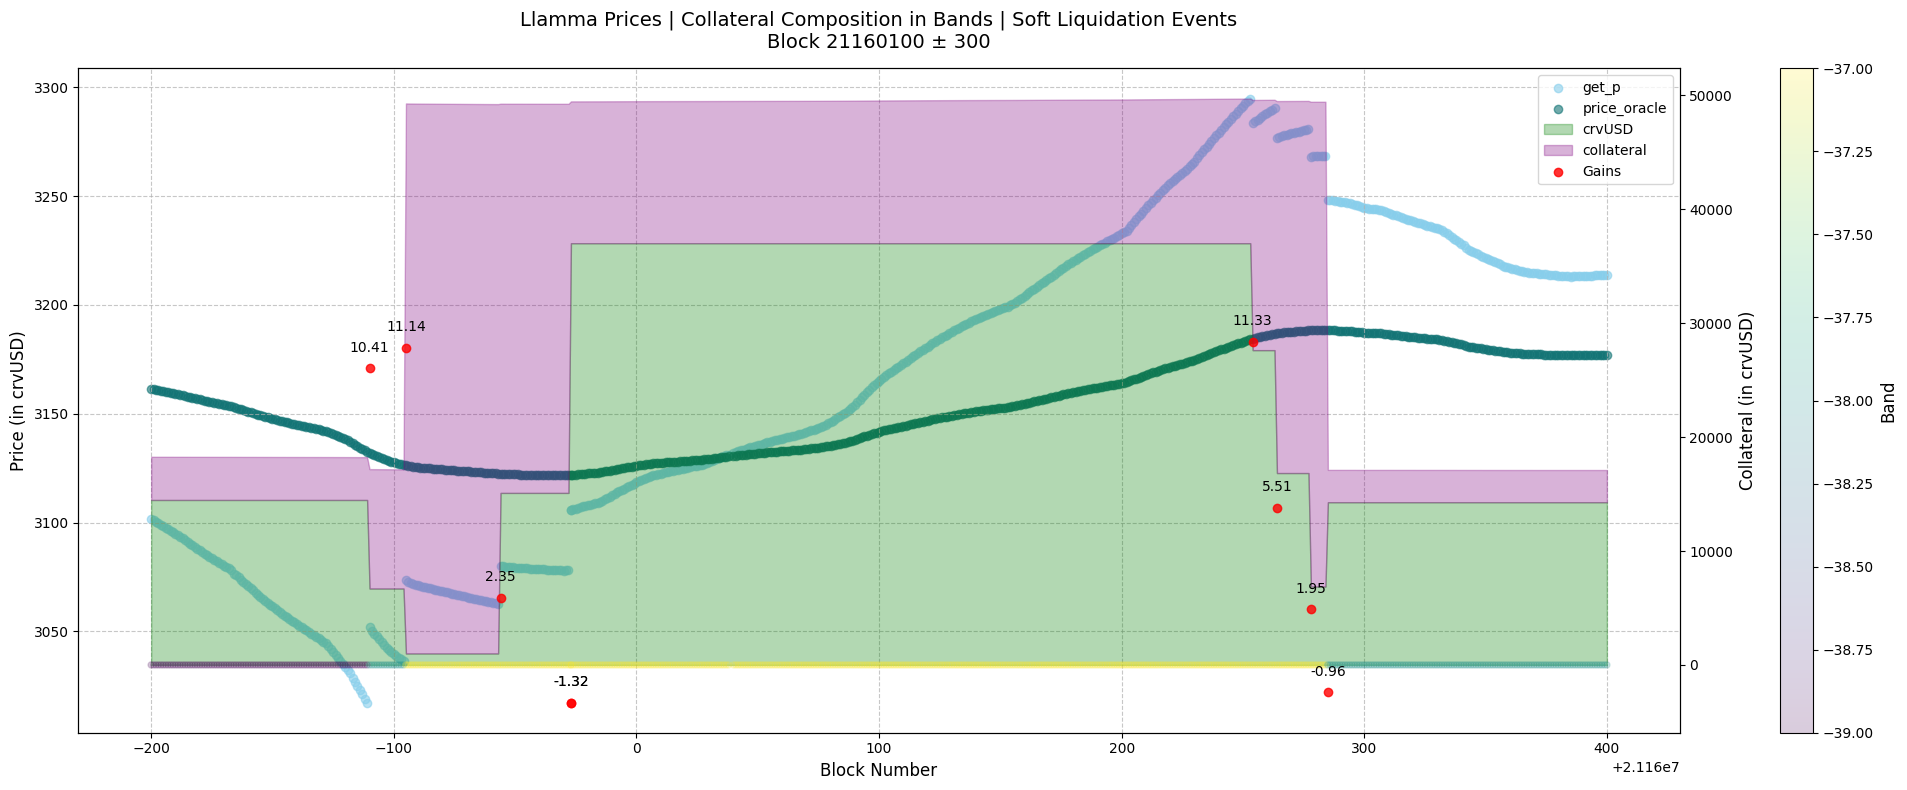

In [10]:
plot_llamma_data(joined_df, 21160100, 300)

---

```
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   blockNumber             346070 non-null  int64  
 1   price_oracle            346070 non-null  float64
 2   get_p                   346070 non-null  float64
 3   delta                   346070 non-null  float64
 4   delta_ratio             346070 non-null  float64
 5   abs_diff                346070 non-null  float64
 6   band                    346070 non-null  float64
 7   amountBorrowableToken   346070 non-null  float64
 8   amountCollatToken       346070 non-null  float64
 9   oraclePrice             346070 non-null  float64
 10  amountCollatTokenInUsd  346070 non-null  float64
 11  amountFullInBandInUsd   346070 non-null  float64
 12  crvUSD                  346070 non-null  float64
 13  collateral              346070 non-null  float64
 14  usdEquivalent           162 non-null     float64
 15  transactionHash         162 non-null     object 
 16  buyer                   162 non-null     object 
 ```

In [11]:
def plot_price_window(df: pd.DataFrame, block_number: int, window_size: int = 100):
    """
    Plot oracle and current prices with derivative for a window of blocks around a specific block number
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing price data with 'blockNumber', 'get_p', 'price_oracle', and 'get_p_derivative' columns
    block_number : int
        The central block number to focus on
    window_size : int
        Number of blocks to show before and after the central block (default: 100)
    """
    # Filter data for the specified window
    mask = (df['blockNumber'] >= block_number - window_size) & \
           (df['blockNumber'] <= block_number + window_size)
    window_df = df[mask]
    
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot price series on primary axis
    ax1.scatter(window_df['blockNumber'], window_df['get_p'], 
               label='get_p', alpha=0.6)
    ax1.scatter(window_df['blockNumber'], window_df['price_oracle'], 
               label='price_oracle', alpha=0.6)
    
    # Add vertical line for the specified block
    ax1.axvline(x=block_number, color='r', linestyle='--', 
                alpha=0.5, label='Selected Block')
    
    # Customize primary axis
    ax1.set_xlabel('Block Number', fontsize=12)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create secondary axis for derivative
    ax2 = ax1.twinx()
    ax2.plot(window_df['blockNumber'], window_df['diff'], 
            color='green', label='Price Derivative', alpha=0.5)
    ax2.set_ylabel('Price Derivative (USD/block)', color='green', fontsize=12)
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Set title
    plt.title(f'Oracle Price vs Current Price Around Block {block_number}', 
             fontsize=14, pad=15)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

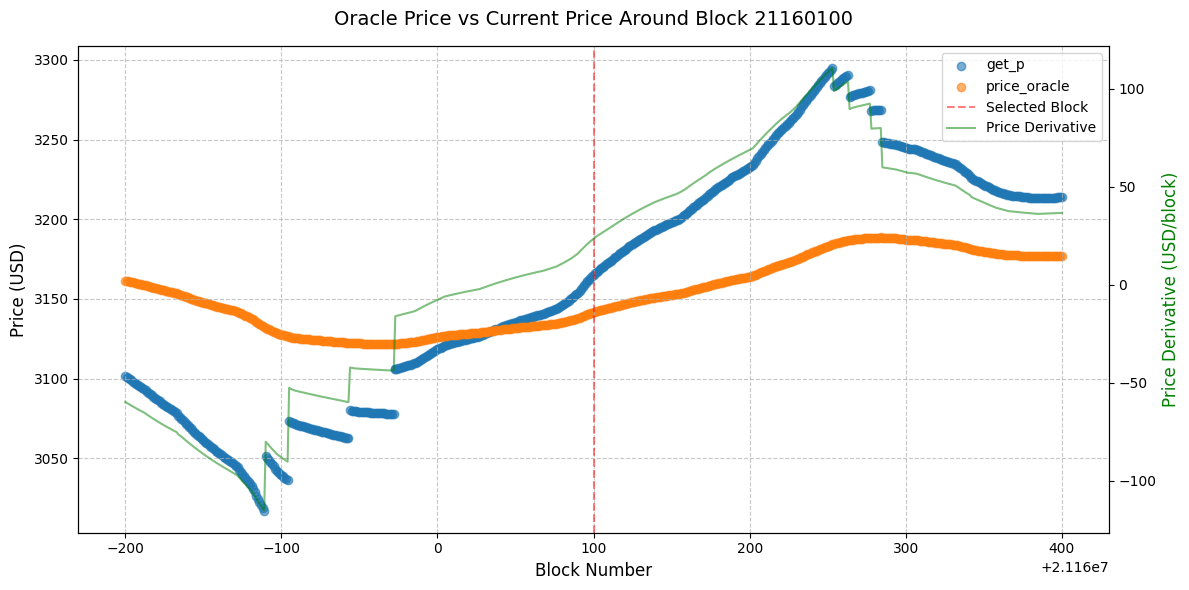

In [12]:
plot_price_window(joined_df, 21160100, 300)

---

In [13]:
joined_df['deviation_product'] = np.where(
    joined_df['diff'] > 0, 
    joined_df['crvUSD'] * joined_df['diff'],
    np.where(
        joined_df['diff'] < 0,
        joined_df['collateral'] * joined_df['diff'],
        0
    )
)

In [29]:
# Calculate the number of blocks for 7 days
blocks_in_7_days = int(7 * 86400 / 12)  # 50400 blocks

# Get the maximum block number
max_block = joined_df['blockNumber'].max()

# Create a dataframe using every 5th row of joined_df
sampled_df = joined_df.iloc[::1].copy()

# Create new dataframe with the last 7 days of blocks
recent_df = joined_df[joined_df['blockNumber'] > (max_block - blocks_in_7_days)].copy()


In [ ]:
print(joined_df.info())
print(sampled_df.info())

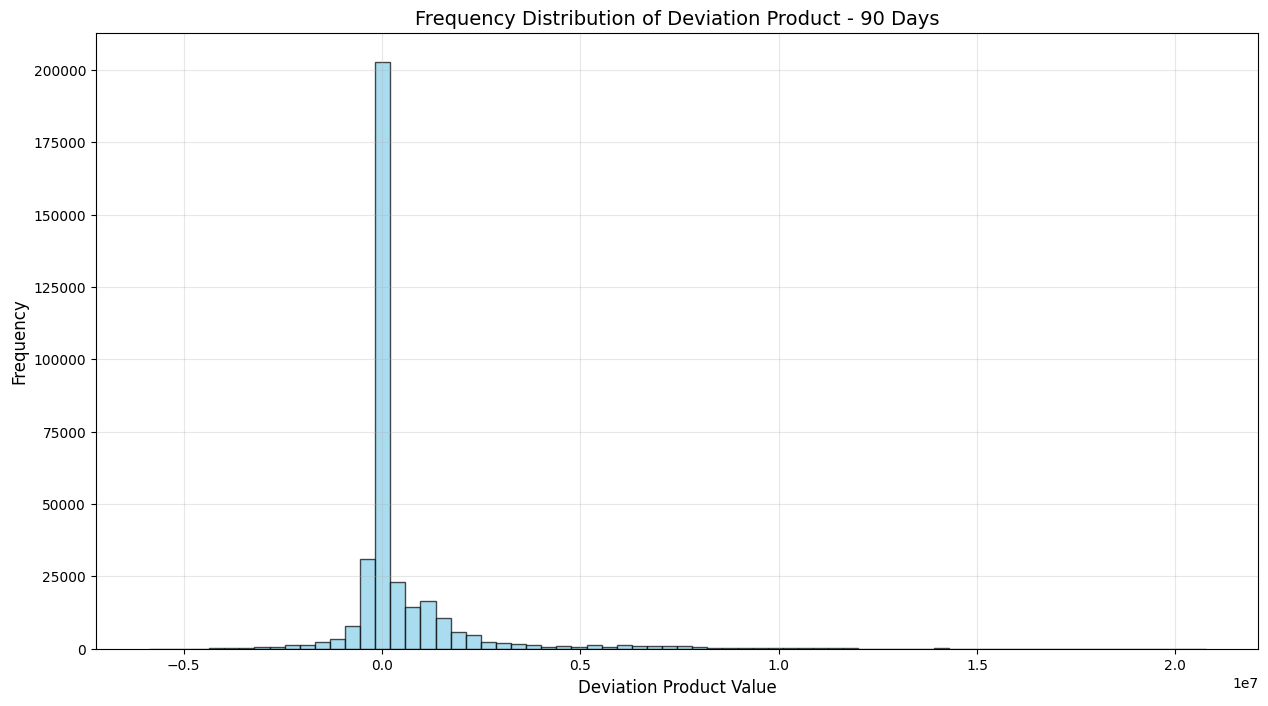

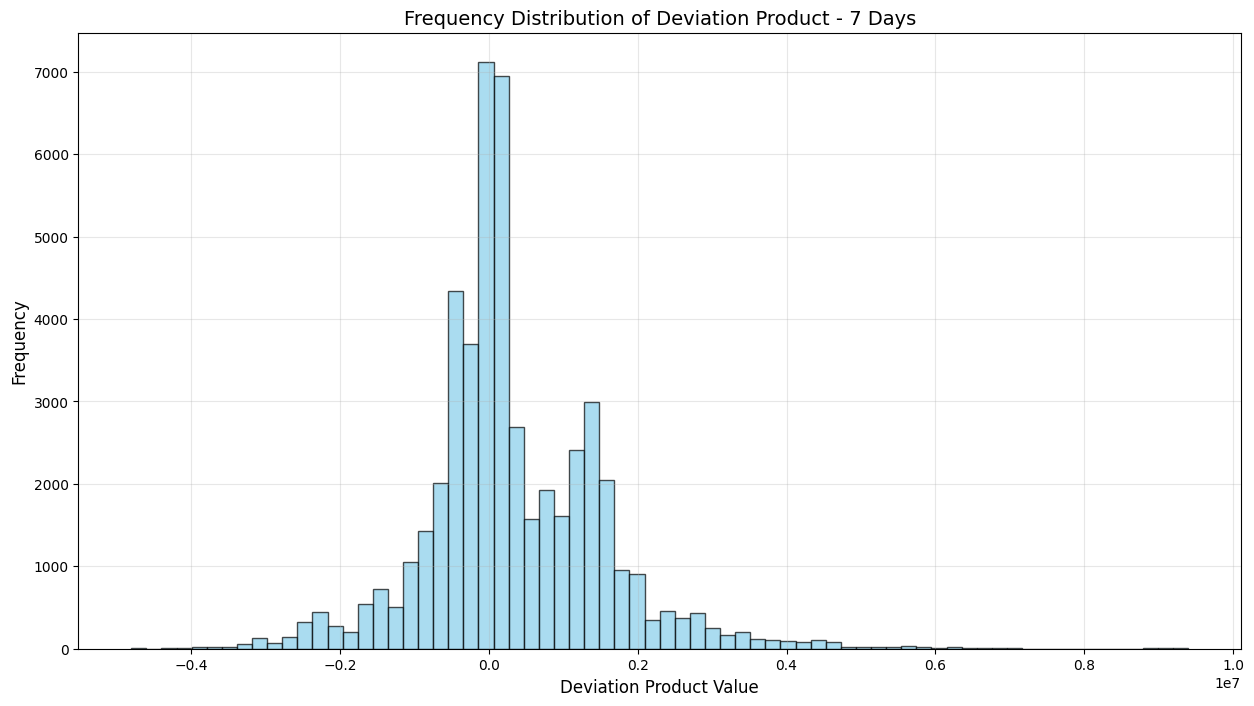

In [32]:
# Create a new figure with a larger size
plt.figure(figsize=(15, 8))

# Create histogram
plt.hist(joined_df['deviation_product'], bins=70, color='skyblue', alpha=0.7, edgecolor='black')

# Add labels and title
plt.xlabel('Deviation Product Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Deviation Product - 90 Days', fontsize=14)

# Add grid for better readability
plt.grid(True, alpha=0.3)
# plt.yscale('log')

# Show the plot
plt.show()



# Create a new figure with a larger size
plt.figure(figsize=(15, 8))

# Create histogram
plt.hist(recent_df['deviation_product'], bins=70, color='skyblue', alpha=0.7, edgecolor='black')

# Add labels and title
plt.xlabel('Deviation Product Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Deviation Product - 7 Days', fontsize=14)

# Add grid for better readability
plt.grid(True, alpha=0.3)
# plt.yscale('log')

# Show the plot
plt.show()


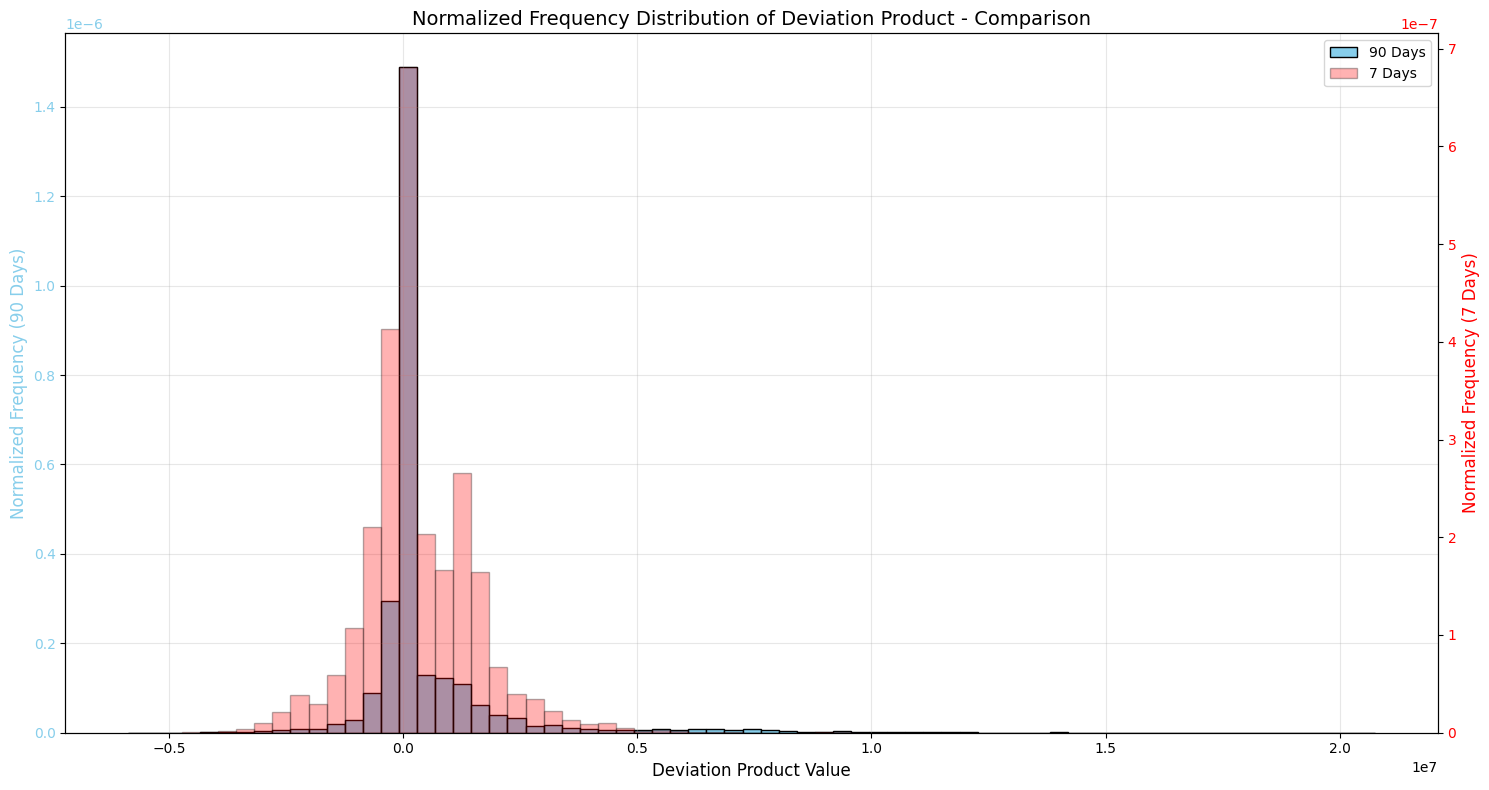

In [37]:
# Create a new figure with a larger size
fig, ax1 = plt.subplots(figsize=(15, 8))

# Calculate bin edges that work for both datasets
min_val = min(joined_df['deviation_product'].min(), recent_df['deviation_product'].min())
max_val = max(joined_df['deviation_product'].max(), recent_df['deviation_product'].max())
bins = np.linspace(min_val, max_val, 70)

# Create histogram for 90 days data on left y-axis
n1, bins1, patches1 = ax1.hist(joined_df['deviation_product'], bins=bins,
                              color='skyblue', alpha=1, edgecolor='black', 
                              label='90 Days', density=True)  # Use density=True to normalize

# Create second y-axis
ax2 = ax1.twinx()

# Create histogram for 7 days data on right y-axis
n2, bins2, patches2 = ax2.hist(recent_df['deviation_product'], bins=bins,
                              color='red', alpha=0.3, edgecolor='black', 
                              label='7 Days', density=True)  # Use density=True to normalize

# Add labels and title
ax1.set_xlabel('Deviation Product Value', fontsize=12)
ax1.set_ylabel('Normalized Frequency (90 Days)', fontsize=12, color='skyblue')
ax2.set_ylabel('Normalized Frequency (7 Days)', fontsize=12, color='red')
plt.title('Normalized Frequency Distribution of Deviation Product - Comparison', fontsize=14)

# Color the tick labels to match the histogram colors
ax1.tick_params(axis='y', labelcolor='skyblue')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend by combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid for better readability
ax1.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

---

In [95]:
from scipy import stats
from scipy.stats import gaussian_kde


def analyze_distributions_combined(reference_df, test_df, column='deviation_product', bins=100):
    """
    Analyzes distributions combining both spread analysis and peak location analysis.
    
    Parameters:
    reference_df: DataFrame with reference distribution
    test_df: DataFrame with test distribution
    column: column name to analyze
    bins: number of bins for histogram
    
    Returns:
    dict: Combined analysis results and scores
    """
    # Get data and handle extreme values
    ref_data = reference_df[column].values
    test_data = test_df[column].values
    
    # Handle infinities and NaNs
    def clean_extreme_values(data):
        # Get max value that's not inf
        max_val = np.nanmax(data[~np.isinf(data)])
        min_val = np.nanmin(data[~np.isinf(data)])
        
        # Replace positive infinities with max value
        data = np.where(data == np.inf, max_val, data)
        # Replace negative infinities with min value
        data = np.where(data == -np.inf, min_val, data)
        # Replace NaNs with 0
        data = np.nan_to_num(data, nan=0.0)
        
        return data
    
    ref_data = clean_extreme_values(ref_data)
    test_data = clean_extreme_values(test_data)
    
    # Calculate reference statistics
    ref_std = np.std(ref_data)
    
    # Spread Analysis
    spread_metrics = {
        'reference': {
            'std': np.std(ref_data),
            'iqr': stats.iqr(ref_data),
            'range': np.ptp(ref_data)
        },
        'test': {
            'std': np.std(test_data),
            'iqr': stats.iqr(test_data),
            'range': np.ptp(test_data)
        }
    }
    
    def spread_ratio_score(test_val, ref_val):
        ratio = test_val / ref_val if ref_val != 0 else float('inf')
        
        if ratio <= 1:  # Test spread is tighter than reference
            # Score from 50 to 100 as ratio goes from 1 to 0
            return 50 + (50 * (1 - ratio))
        else:  # Test spread is wider than reference
            # Score from 50 to 0 as ratio goes from 1 to 25
            return max(0, 50 * (25 - ratio) / 24)
    
    spread_score = np.mean([
        spread_ratio_score(spread_metrics['test']['std'], spread_metrics['reference']['std']),
        spread_ratio_score(spread_metrics['test']['iqr'], spread_metrics['reference']['iqr']),
        spread_ratio_score(spread_metrics['test']['range'], spread_metrics['reference']['range'])
    ])
    
    # Peak Analysis
    def find_distribution_peak(data):
        kde = gaussian_kde(data)
        x_range = np.linspace(np.min(data), np.max(data), 1000)
        density = kde(x_range)
        peak_idx = np.argmax(density)
        return x_range[peak_idx]
    
    ref_peak = find_distribution_peak(ref_data)
    test_peak = find_distribution_peak(test_data)
    
    # Calculate peak difference in terms of reference standard deviations
    peak_diff_in_stds = abs(test_peak - ref_peak) / ref_std
    peak_score = 100 * np.exp(-peak_diff_in_stds*5)
    
    # Visualization
    fig = plt.figure(figsize=(15, 12))  # Increased height to accommodate new plot
    gs = plt.GridSpec(2, 2, height_ratios=[1, 1])

    # Plot 1: Distribution comparison with KDE (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Plot 2: Box plots for spread comparison (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Plot 3: Zoomed view (bottom)
    ax3 = fig.add_subplot(gs[1, :])  # Span both columns
    
    # Plot 1: Distribution comparison with KDE
    def plot_dist_with_peak(ax, data, label, peak):
        kde = gaussian_kde(data)
        x_range = np.linspace(np.min(data), np.max(data), 1000)
        density = kde(x_range)
        
        ax.hist(data, bins=bins, density=True, alpha=0.3, label=f'{label} Histogram')
        ax.plot(x_range, density, label=f'{label} KDE')
        ax.axvline(x=peak, color='r' if label=='Test' else 'b', 
                  linestyle='--', alpha=0.5,
                  label=f'{label} Peak: {peak:.2e}')
    
    plot_dist_with_peak(ax1, ref_data, 'Reference', ref_peak)
    plot_dist_with_peak(ax1, test_data, 'Test', test_peak)
    ax1.set_title('Distribution Comparison')
    ax1.legend()
    ax1.set_ylabel('Density')
    
    # Plot 2: Box plots for spread comparison
    ax2.boxplot([ref_data, test_data], tick_labels=['Reference', 'Test'])    
    ax2.set_title('Spread Comparison')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # Plot 3: Zoomed view
    window = 4 * ref_std  # Show ±4 standard deviations around reference peak
    plot_dist_with_peak(ax3, ref_data, 'Reference', ref_peak)
    plot_dist_with_peak(ax3, test_data, 'Test', test_peak)
    ax3.set_xlim(ref_peak - window/2, ref_peak + window/2)
    ax3.set_title('Zoomed View Around Reference Peak')
    ax3.legend()
    ax3.set_xlabel('Value')
    ax3.set_ylabel('Density')
    
    plt.tight_layout()
    
    # Calculate overall score
    overall_score = (spread_score + peak_score) / 2
    
    output_dict = {
        'spread_analysis': {
            'score': spread_score,
            'metrics': spread_metrics
        },
        'peak_analysis': {
            'score': peak_score,
            'metrics': {
                'reference_peak': ref_peak,
                'test_peak': test_peak,
                'difference_in_std_units': peak_diff_in_stds,
                'reference_std': ref_std,
                'absolute_difference': abs(test_peak - ref_peak)
            }
        },
        'overall_score': overall_score
    }
    
    print(json.dumps(output_dict, indent=4))
    
    return output_dict

{
    "spread_analysis": {
        "score": 50.0,
        "metrics": {
            "reference": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            },
            "test": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            }
        }
    },
    "peak_analysis": {
        "score": 100.0,
        "metrics": {
            "reference_peak": 14251.986662063748,
            "test_peak": 14251.986662063748,
            "difference_in_std_units": 0.0,
            "reference_std": 1566172.9802697,
            "absolute_difference": 0.0
        }
    },
    "overall_score": 75.0
}


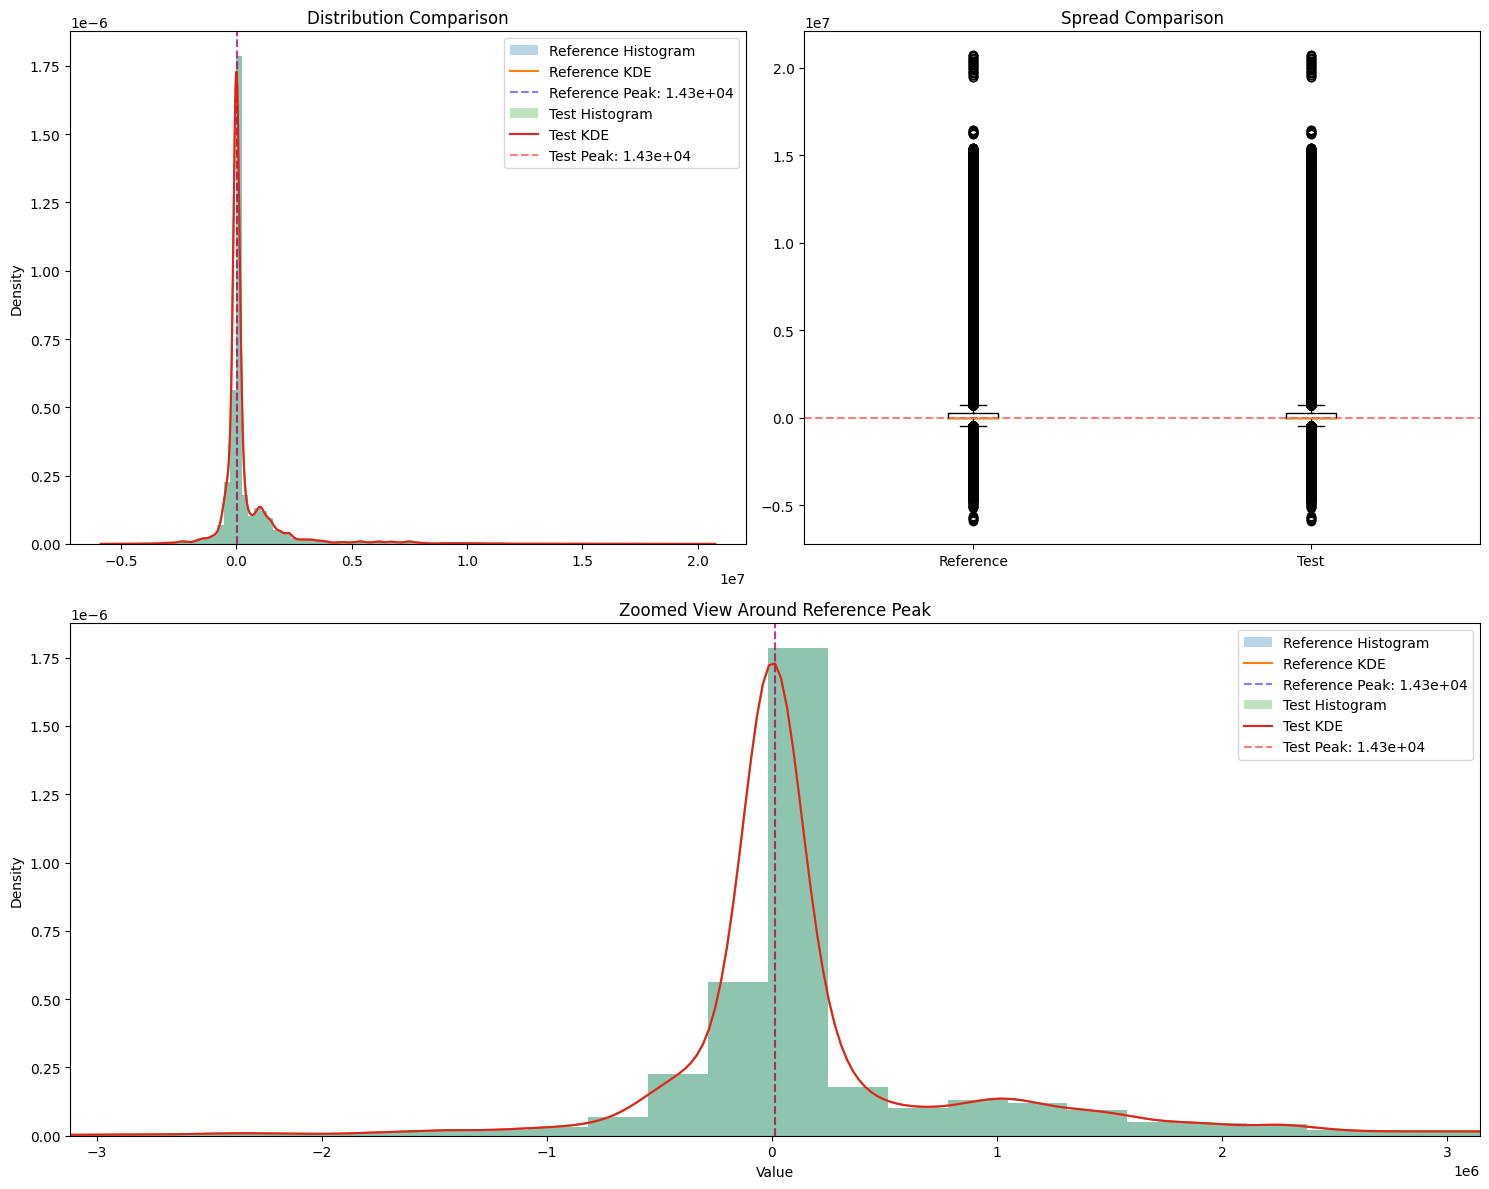

In [85]:
# For the 100% matched data
analysis = analyze_distributions_combined(joined_df, joined_df)

{
    "spread_analysis": {
        "score": 59.20728624528061,
        "metrics": {
            "reference": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            },
            "test": {
                "std": 1204641.9387078695,
                "iqr": 1392111.235248369,
                "range": 14201909.156186275
            }
        }
    },
    "peak_analysis": {
        "score": 91.62780944807079,
        "metrics": {
            "reference_peak": 14251.986662063748,
            "test_peak": 41639.76751948707,
            "difference_in_std_units": 0.017487072757893612,
            "reference_std": 1566172.9802697,
            "absolute_difference": 27387.78085742332
        }
    },
    "overall_score": 75.4175478466757
}


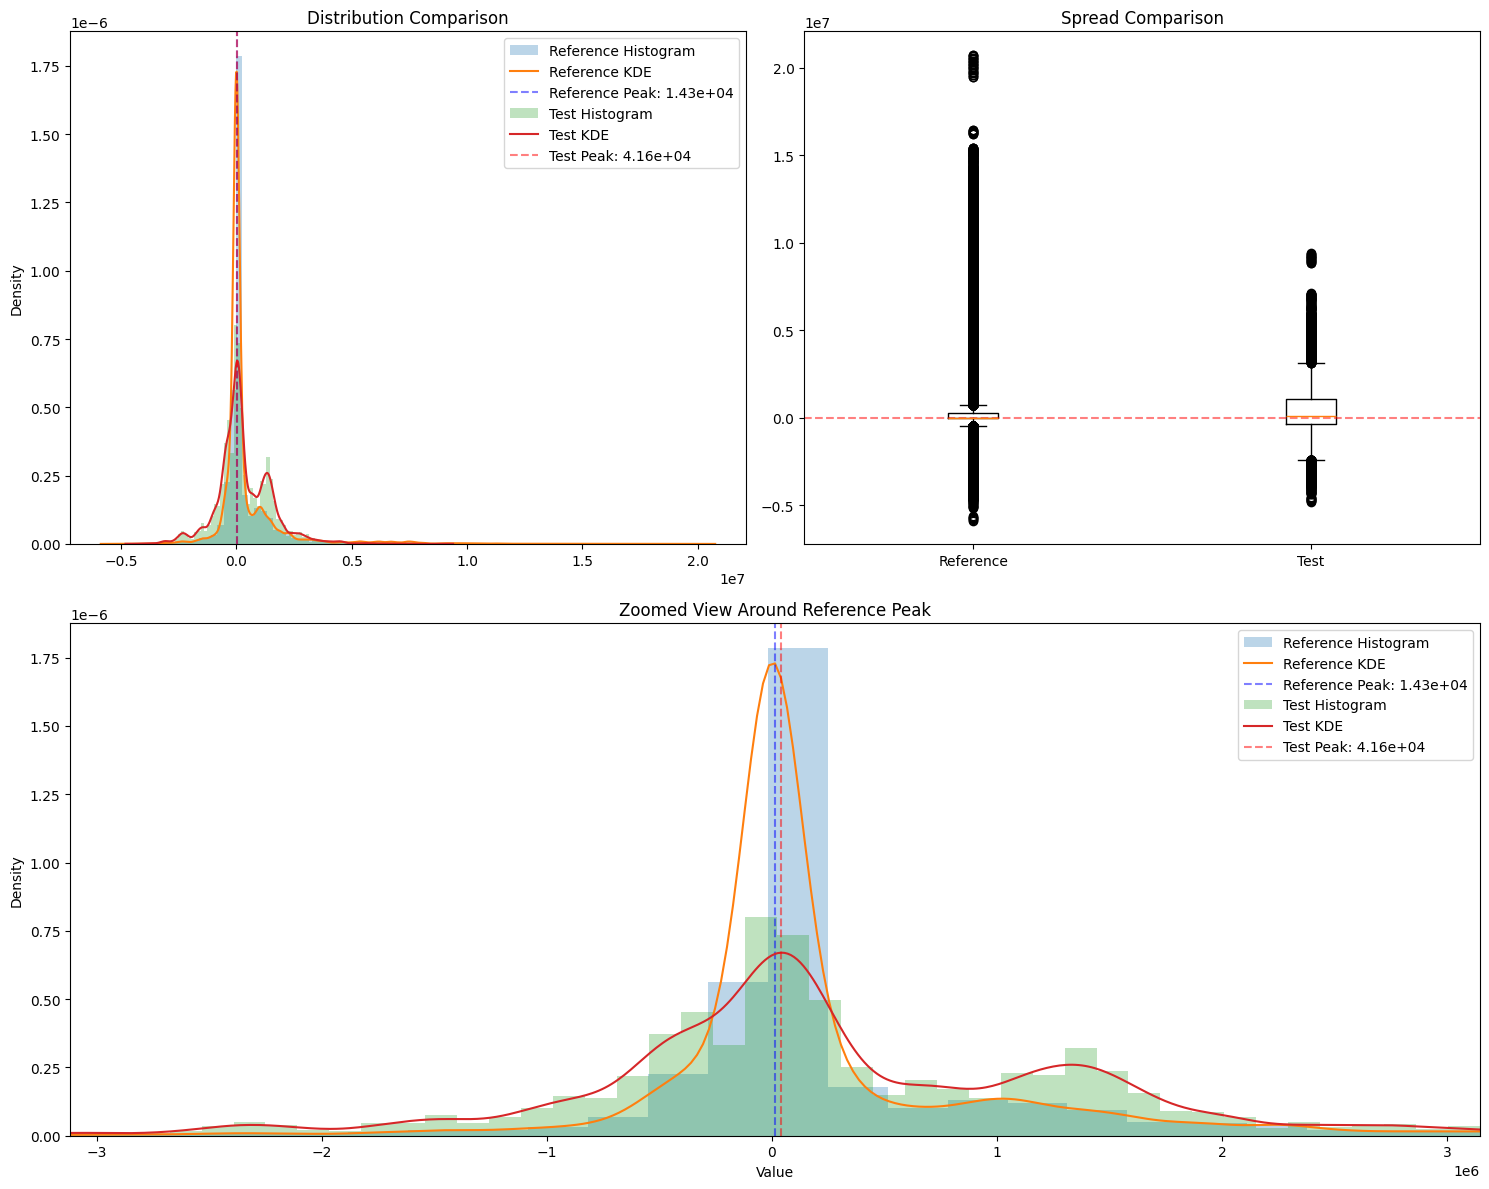

In [96]:
# 30d vs 7d
analysis = analyze_distributions_combined(joined_df, recent_df)

{
    "spread_analysis": {
        "score": 48.958333333333336,
        "metrics": {
            "reference": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            },
            "test": {
                "std": 2349259.4704045495,
                "iqr": 465414.04226980684,
                "range": 39958743.52404723
            }
        }
    },
    "peak_analysis": {
        "score": 97.75071224356527,
        "metrics": {
            "reference_peak": 14251.986662063748,
            "test_peak": 21377.97999309562,
            "difference_in_std_units": 0.004549940153995477,
            "reference_std": 1566172.9802697,
            "absolute_difference": 7125.993331031874
        }
    },
    "overall_score": 73.3545227884493
}


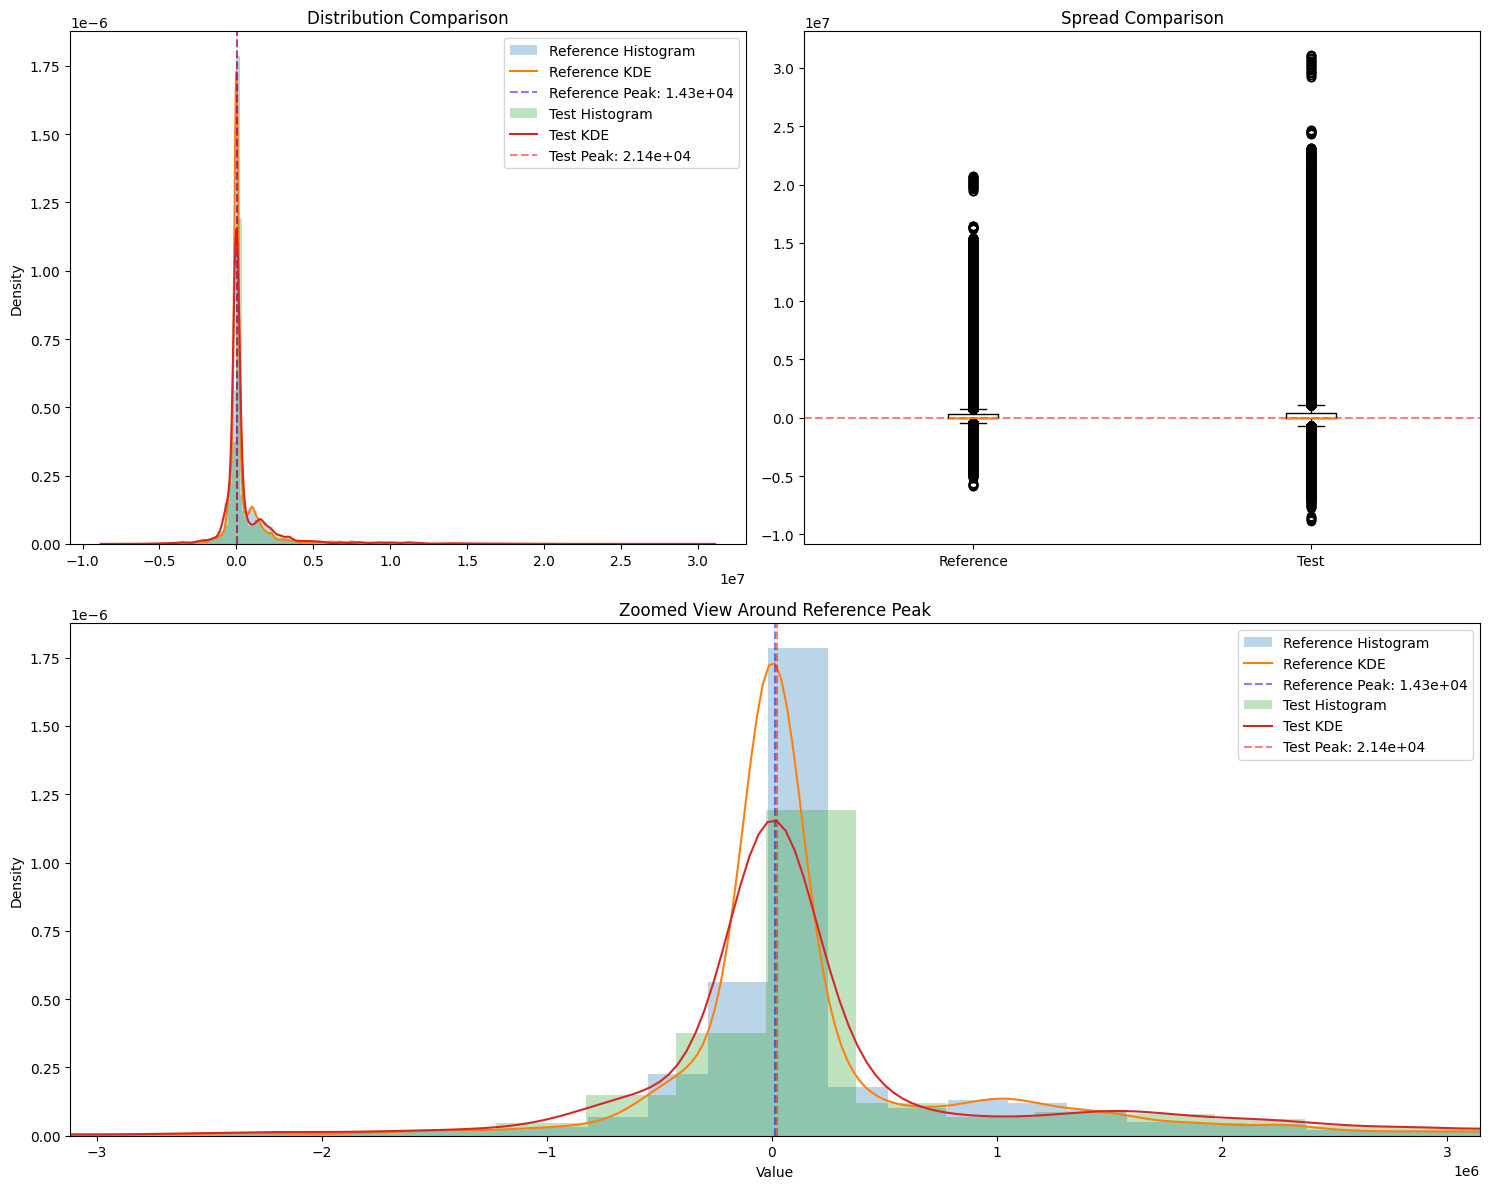

In [97]:
test_df1 = joined_df.copy()

test_df1['deviation_product'] = test_df1['deviation_product'] * 1.5

analysis = analyze_distributions_combined(joined_df, test_df1)

{
    "spread_analysis": {
        "score": 42.70836869447987,
        "metrics": {
            "reference": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            },
            "test": {
                "std": 7501147.692284976,
                "iqr": 1073505.8271958367,
                "range": 139872435.06887951
            }
        }
    },
    "peak_analysis": {
        "score": 85.70900128088013,
        "metrics": {
            "reference_peak": 14251.986662063748,
            "test_peak": 62556.62463708222,
            "difference_in_std_units": 0.030842466690173813,
            "reference_std": 1566172.9802697,
            "absolute_difference": 48304.63797501847
        }
    },
    "overall_score": 64.20868498768
}


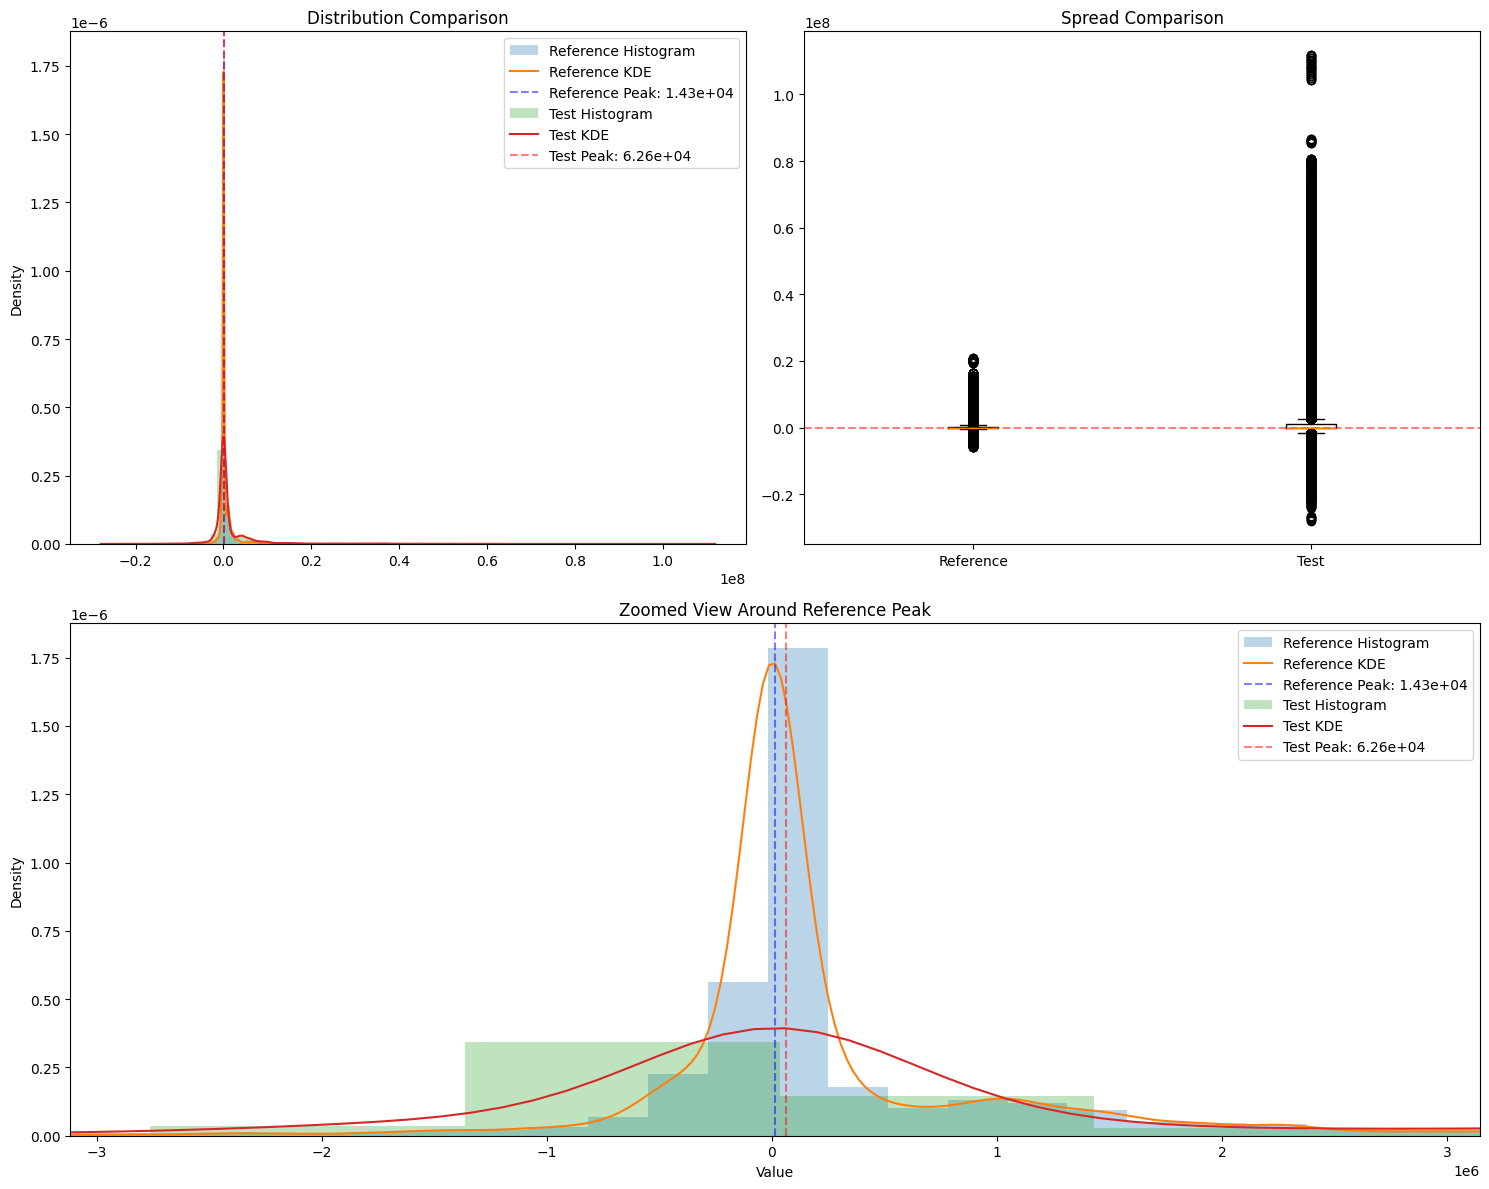

In [98]:
test_df2 = joined_df.copy()

test_df2['deviation_product'] = np.sign(test_df2['deviation_product']) *\
    np.abs(test_df2['deviation_product']) ** 1.1
    
analysis = analyze_distributions_combined(joined_df, test_df2)

{
    "spread_analysis": {
        "score": 60.0,
        "metrics": {
            "reference": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            },
            "test": {
                "std": 1252938.3842157598,
                "iqr": 248220.822543897,
                "range": 21311329.879491862
            }
        }
    },
    "peak_analysis": {
        "score": 99.72737588709535,
        "metrics": {
            "reference_peak": 14251.986662063748,
            "test_peak": 11401.589329651557,
            "difference_in_std_units": 0.0018199760615978339,
            "reference_std": 1566172.9802697,
            "absolute_difference": 2850.3973324121907
        }
    },
    "overall_score": 79.86368794354767
}


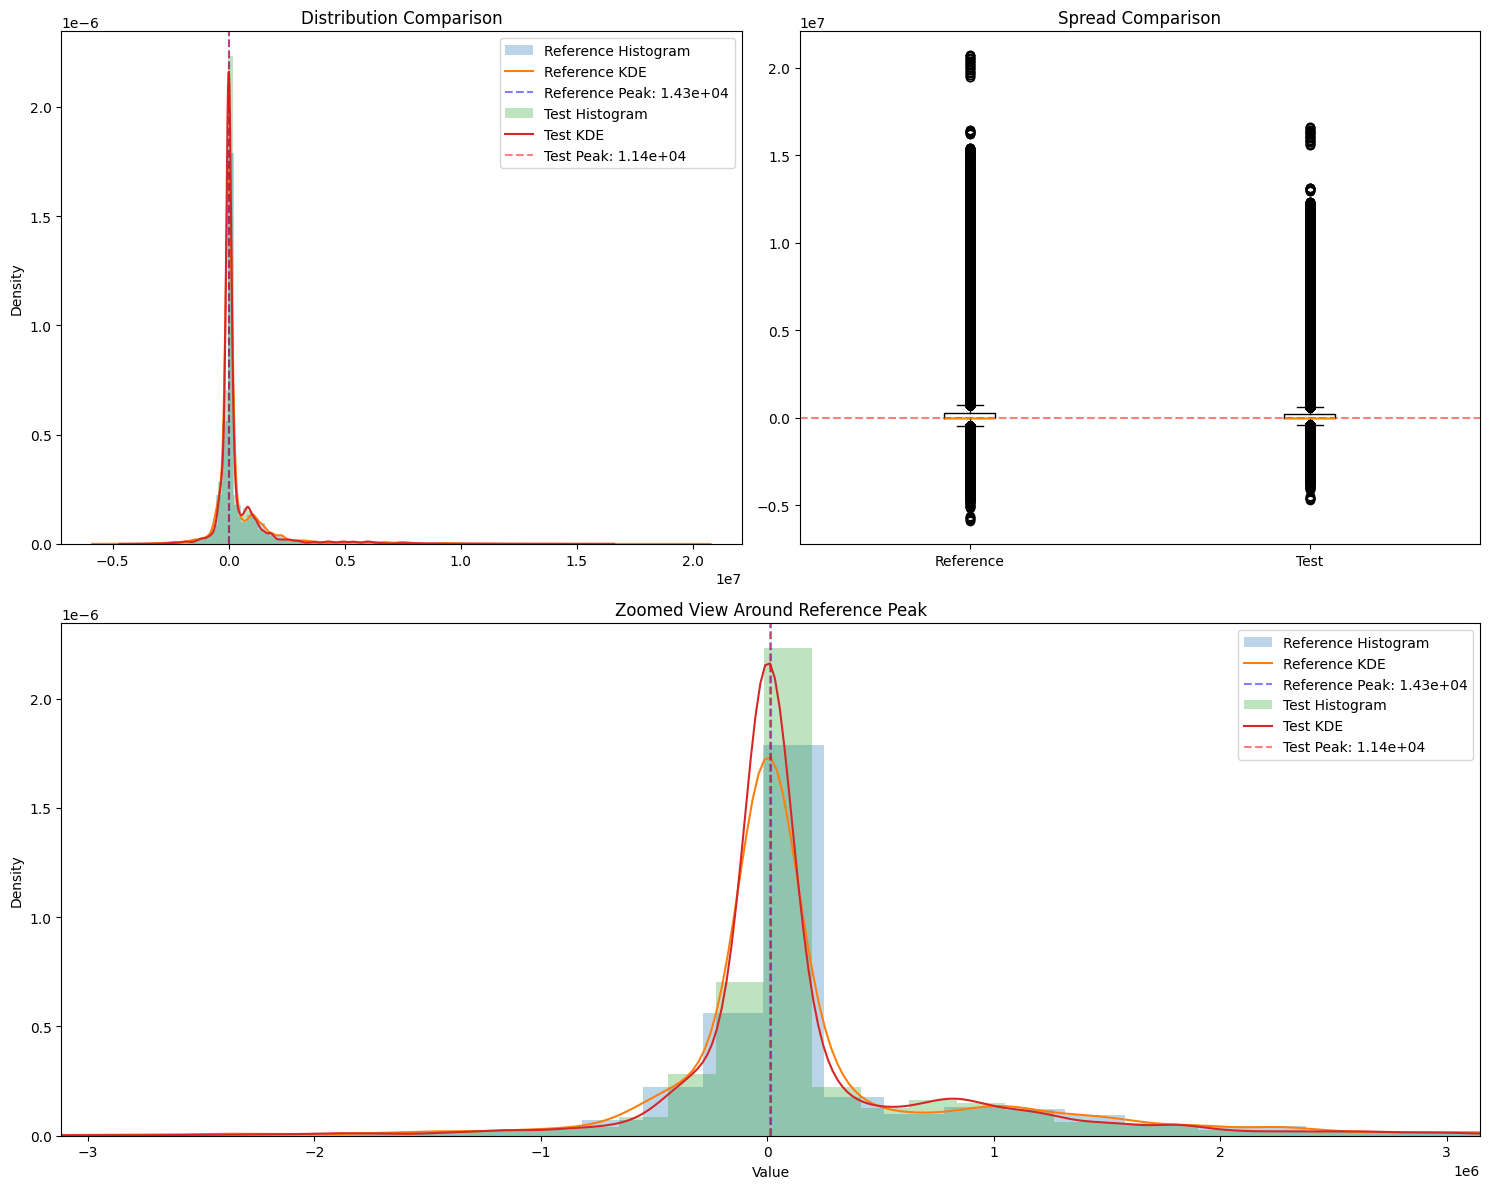

In [89]:
test_df3 = joined_df.copy()

test_df3['deviation_product'] = test_df3['deviation_product'] * 0.8

analysis = analyze_distributions_combined(joined_df, test_df3)

{
    "spread_analysis": {
        "score": 50.0,
        "metrics": {
            "reference": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            },
            "test": {
                "std": 1566172.9802697,
                "iqr": 310276.02817987127,
                "range": 26639162.349364825
            }
        }
    },
    "peak_analysis": {
        "score": 4.106925965563861,
        "metrics": {
            "reference_peak": 14251.986662063748,
            "test_peak": 1014251.9866620637,
            "difference_in_std_units": 0.6384990755157817,
            "reference_std": 1566172.9802697,
            "absolute_difference": 1000000.0
        }
    },
    "overall_score": 27.05346298278193
}


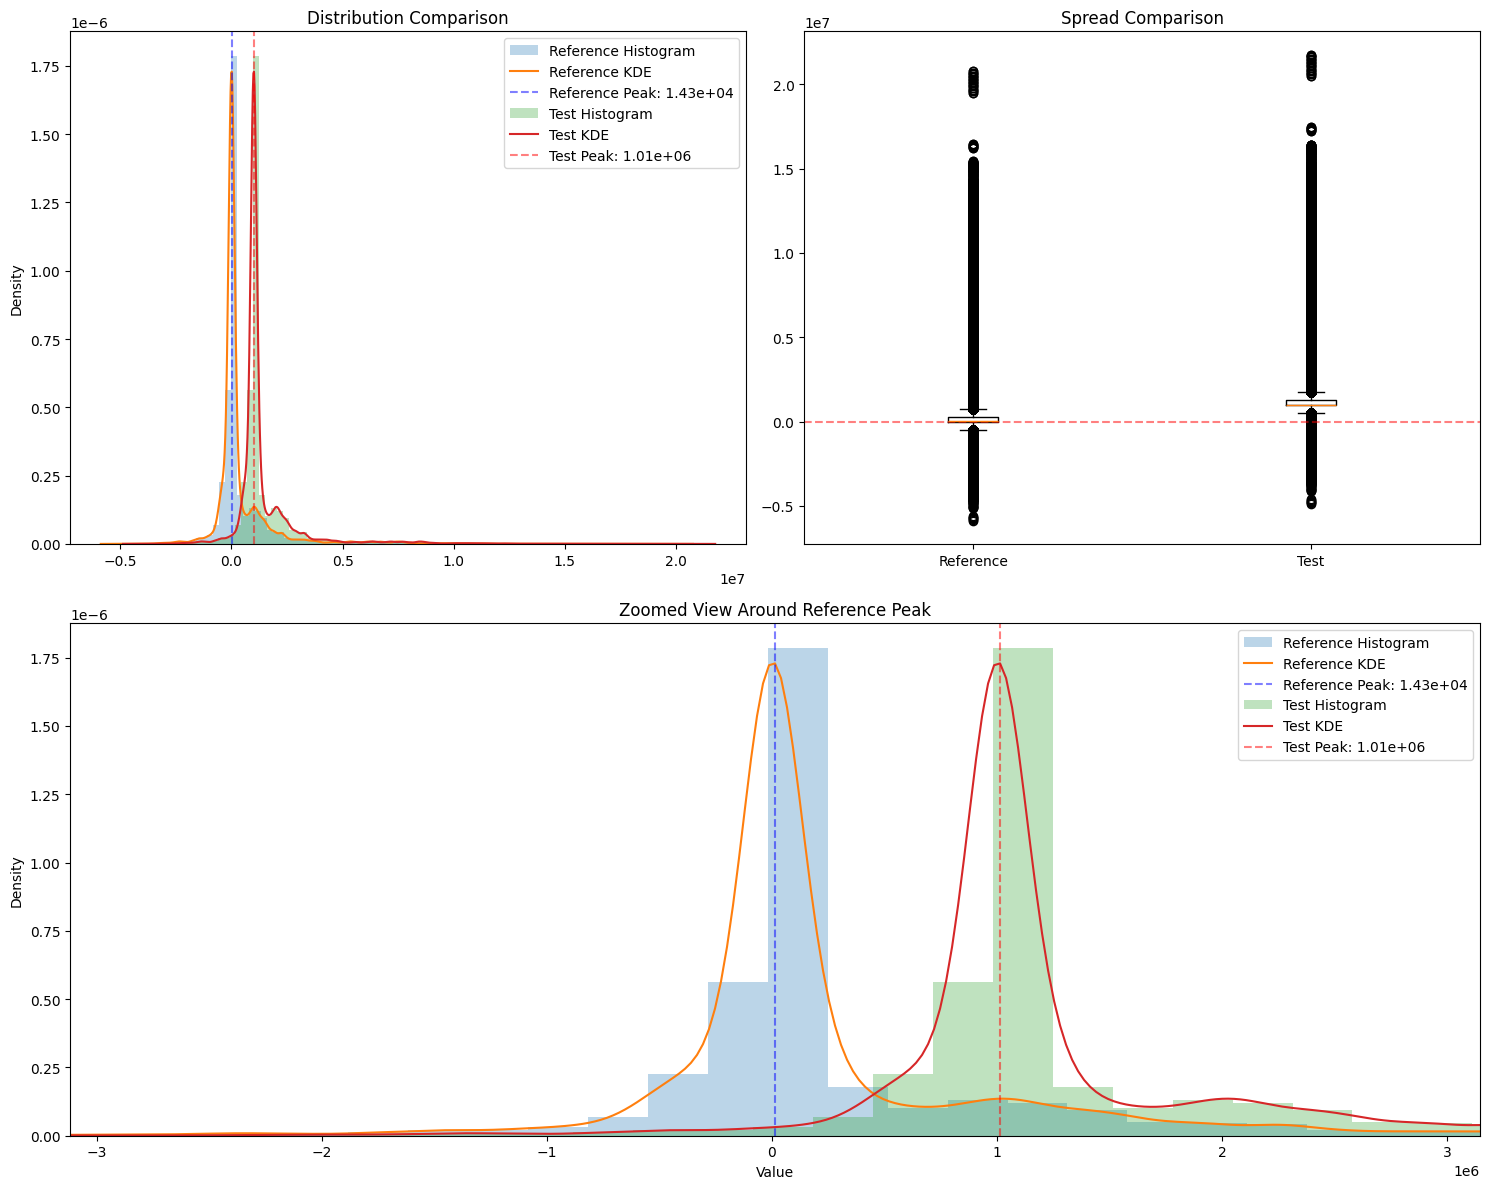

In [99]:
test_df4 = joined_df.copy()

test_df4['deviation_product'] = test_df4['deviation_product'] + 1000000

analysis = analyze_distributions_combined(joined_df, test_df4)

{
    "spread_analysis": {
        "score": 50.0,
        "metrics": {
            "reference": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            },
            "test": {
                "std": 1566172.9802697,
                "iqr": 310276.0281798712,
                "range": 26639162.349364825
            }
        }
    },
    "peak_analysis": {
        "score": 52.808444438531254,
        "metrics": {
            "reference_peak": 14251.986662063748,
            "test_peak": 214251.98666206375,
            "difference_in_std_units": 0.12769981510315634,
            "reference_std": 1566172.9802697,
            "absolute_difference": 200000.0
        }
    },
    "overall_score": 51.40422221926563
}


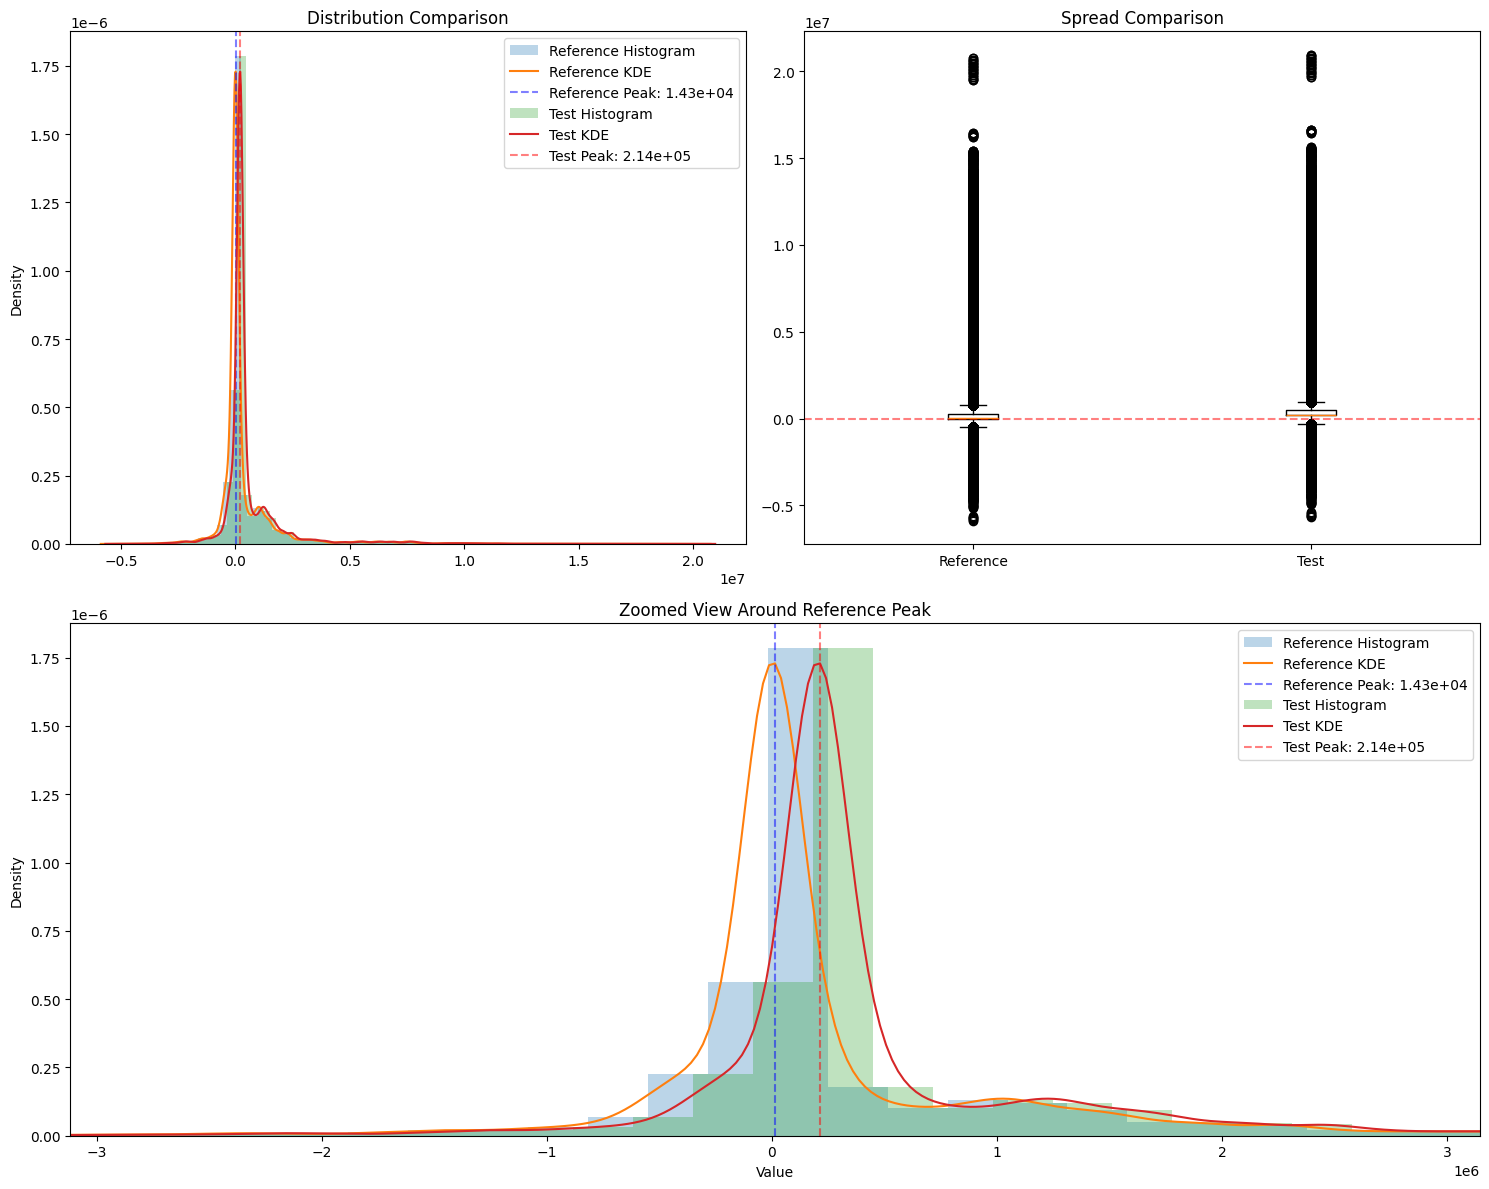

In [103]:
test_df5 = joined_df.copy()

test_df5['deviation_product'] = test_df5['deviation_product'] + 200000

analysis = analyze_distributions_combined(joined_df, test_df5)

---

## Obsolete

In [17]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def evaluate_distribution_divergence(reference_df, test_df, column='deviation_product', bins=50):
    """
    Evaluates the Jensen-Shannon divergence between reference and test distributions
    and provides continuous monitoring metrics.
    
    Parameters:
    reference_df: DataFrame containing the reference distribution
    test_df: DataFrame containing the test distribution
    column: str, column name to analyze
    bins: int, number of bins for histogram
    
    Returns:
    dict: Dictionary containing evaluation metrics and visualization
    """
    # Extract the data
    reference_data = reference_df[column].values
    test_data = test_df[column].values
    
    
    # Remove infinities and NaNs
    reference_data = reference_data[np.isfinite(reference_data)]
    test_data = test_data[np.isfinite(test_data)]
    
    # # Handle extreme values by clipping
    # percentile_99 = np.percentile(np.concatenate([reference_data, test_data]), 99)
    # percentile_1 = np.percentile(np.concatenate([reference_data, test_data]), 1)
    
    # reference_data = np.clip(reference_data, percentile_1, percentile_99)
    # test_data = np.clip(test_data, percentile_1, percentile_99)
    
    
    # Calculate basic statistics
    stats = {
        'reference_mean': np.mean(reference_data),
        'reference_std': np.std(reference_data),
        'test_mean': np.mean(test_data),
        'test_std': np.std(test_data),
        'mean_difference_pct': ((np.mean(test_data) - np.mean(reference_data)) / np.mean(reference_data)) * 100,
        'std_difference_pct': ((np.std(test_data) - np.std(reference_data)) / np.std(reference_data)) * 100
    }
    
    # Calculate histograms for Jensen-Shannon divergence
    hist_range = (min(reference_data.min(), test_data.min()), 
                 max(reference_data.max(), test_data.max()))
    
    hist1, bin_edges = np.histogram(reference_data, bins=bins, range=hist_range, density=True)
    hist2, _ = np.histogram(test_data, bins=bin_edges, density=True)
    
    # Add small constant to avoid division by zero
    hist1 = hist1 + 1e-10
    hist2 = hist2 + 1e-10
    
    # Normalize histograms
    hist1 = hist1 / hist1.sum()
    hist2 = hist2 / hist2.sum()
    
    # Calculate Jensen-Shannon divergence
    js_divergence = jensenshannon(hist1, hist2)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot histograms
    ax1.hist(reference_data, bins=bins, alpha=0.5, density=True, label='Reference')
    ax1.hist(test_data, bins=bins, alpha=0.5, density=True, label='Test')
    ax1.set_title('Distribution Comparison')
    ax1.legend()
    
    # Plot KDE
    kde_ref = gaussian_kde(reference_data)
    kde_test = gaussian_kde(test_data)
    x_eval = np.linspace(hist_range[0], hist_range[1], 200)
    ax2.plot(x_eval, kde_ref(x_eval), label='Reference KDE')
    ax2.plot(x_eval, kde_test(x_eval), label='Test KDE')
    ax2.set_title('Kernel Density Estimation')
    ax2.legend()
    
    plt.tight_layout()
    
    # Calculate divergence score
    # Normalize JS divergence to a 0-100 scale where 0 is perfect match
    divergence_score = (1 - js_divergence) * 100
    
    # Set up evaluation criteria
    evaluation = {
        'divergence_score': divergence_score,
        'js_divergence': js_divergence,
        'statistics': stats,
        'evaluation': {
            'distribution_similarity': 'High' if js_divergence < 0.1 else 'Medium' if js_divergence < 0.3 else 'Low',
            'mean_deviation_acceptable': abs(stats['mean_difference_pct']) < 10,
            'std_deviation_acceptable': abs(stats['std_difference_pct']) < 15
        }
    }
    
    return evaluation

def print_evaluation(eval_results):
    """
    Prints a formatted evaluation report.
    """
    print("\n=== Distribution Evaluation Report ===")
    print(f"\nOverall Similarity Score: {eval_results['divergence_score']:.2f}/100")
    print(f"Jensen-Shannon Divergence: {eval_results['js_divergence']:.4f}")
    
    print("\nStatistical Measures:")
    print(f"Mean Difference: {eval_results['statistics']['mean_difference_pct']:.2f}%")
    print(f"Standard Deviation Difference: {eval_results['statistics']['std_difference_pct']:.2f}%")
    
    print("\nEvaluation Results:")
    print(f"Distribution Similarity: {eval_results['evaluation']['distribution_similarity']}")
    print(f"Mean Deviation Acceptable: {'Yes' if eval_results['evaluation']['mean_deviation_acceptable'] else 'No'}")
    print(f"Std Deviation Acceptable: {'Yes' if eval_results['evaluation']['std_deviation_acceptable'] else 'No'}")




=== Distribution Evaluation Report ===

Overall Similarity Score: 99.39/100
Jensen-Shannon Divergence: 0.0061

Statistical Measures:
Mean Difference: 0.26%
Standard Deviation Difference: 0.30%

Evaluation Results:
Distribution Similarity: High
Mean Deviation Acceptable: Yes
Std Deviation Acceptable: Yes


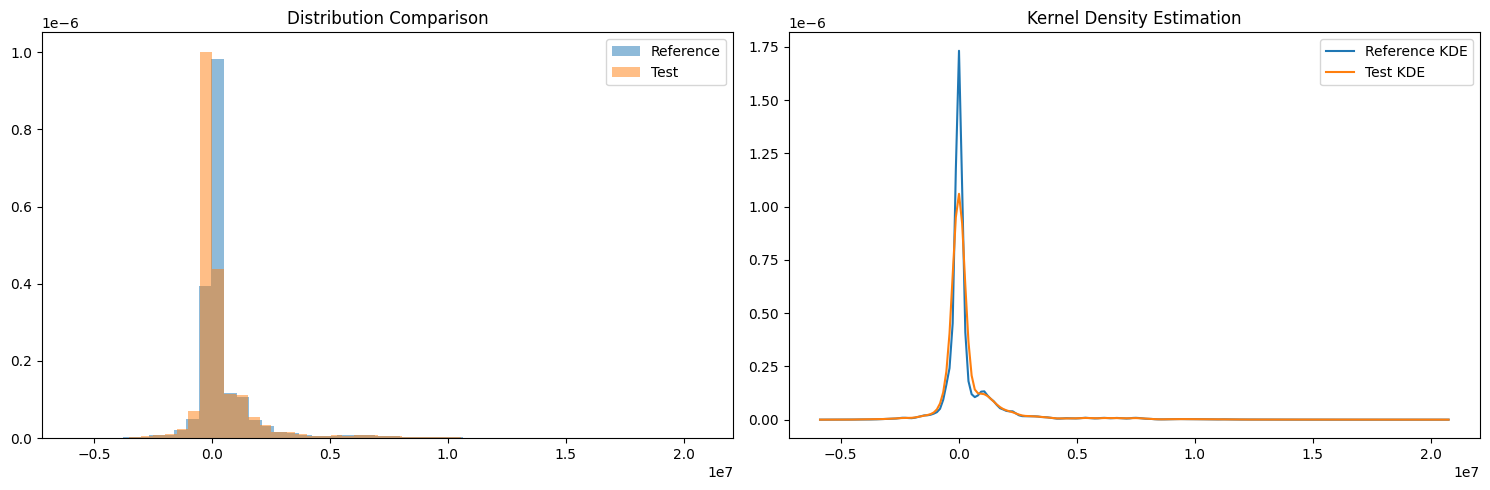

In [18]:
# Example usage
evaluation = evaluate_distribution_divergence(joined_df, sampled_df)
print_evaluation(evaluation)


=== Distribution Evaluation Report ===

Overall Similarity Score: 76.48/100
Jensen-Shannon Divergence: 0.2352

Statistical Measures:
Mean Difference: -29.39%
Standard Deviation Difference: -23.08%

Evaluation Results:
Distribution Similarity: Medium
Mean Deviation Acceptable: No
Std Deviation Acceptable: No


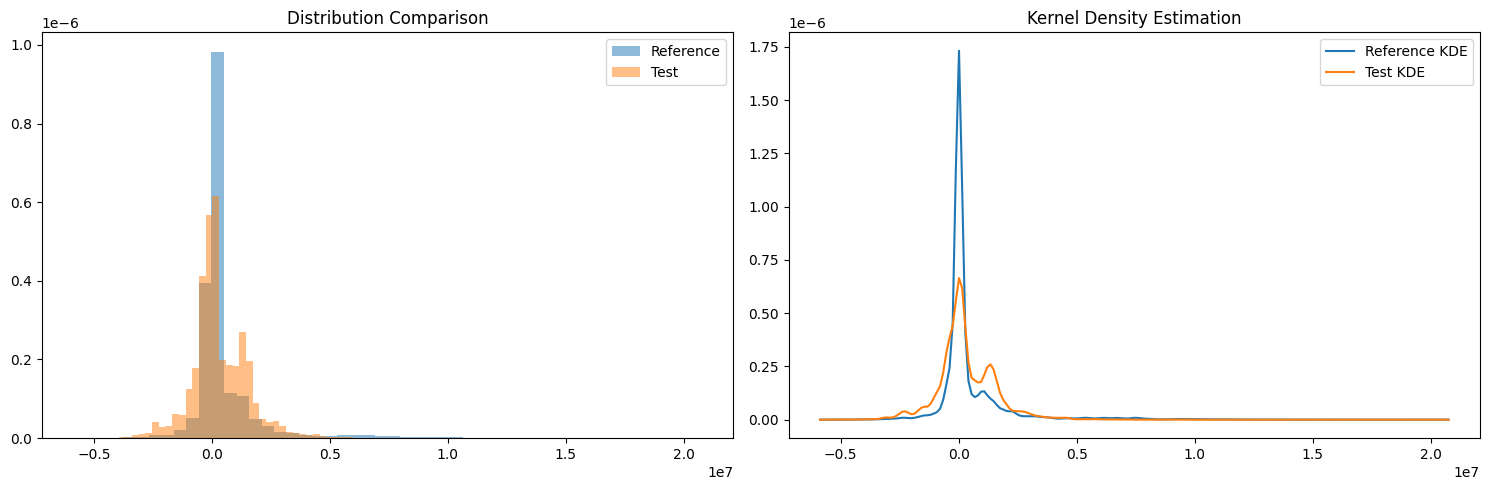

In [19]:
# Example usage
evaluation = evaluate_distribution_divergence(joined_df, recent_df)
print_evaluation(evaluation)

In [20]:
recent_df_test1 = recent_df.copy()
recent_df_test1['deviation_product'] = np.sign(recent_df_test1['deviation_product']) *\
    np.abs(recent_df_test1['deviation_product']) ** 1.1

recent_df_test2 = recent_df.copy()
recent_df_test2['deviation_product'] = recent_df_test2['deviation_product'] * 1.5

recent_df_test3 = recent_df.copy()
recent_df_test3['deviation_product'] = recent_df_test3['deviation_product'] * 0.8

recent_df_test4 = recent_df.copy()
recent_df_test4['deviation_product'] = recent_df_test4['deviation_product'] + 1000000

recent_df_test5 = recent_df.copy()
recent_df_test5['deviation_product'] = recent_df_test5['deviation_product'] - 1000000



=== Distribution Evaluation Report ===

Overall Similarity Score: 59.58/100
Jensen-Shannon Divergence: 0.4042

Statistical Measures:
Mean Difference: 204.57%
Standard Deviation Difference: 233.98%

Evaluation Results:
Distribution Similarity: Low
Mean Deviation Acceptable: No
Std Deviation Acceptable: No

=== Peak Analysis Report ===

Peak Score (0-100): 93.37

Detailed Metrics:
Reference Peak Location: 1.43e+04
Test Peak Location: 1.22e+05
Absolute Peak Difference: 1.07e+05
Reference Standard Deviation: 1.57e+06
Peak Difference in Standard Deviation Units: 0.07

Interpretation: Excellent match (within 0.5 std)


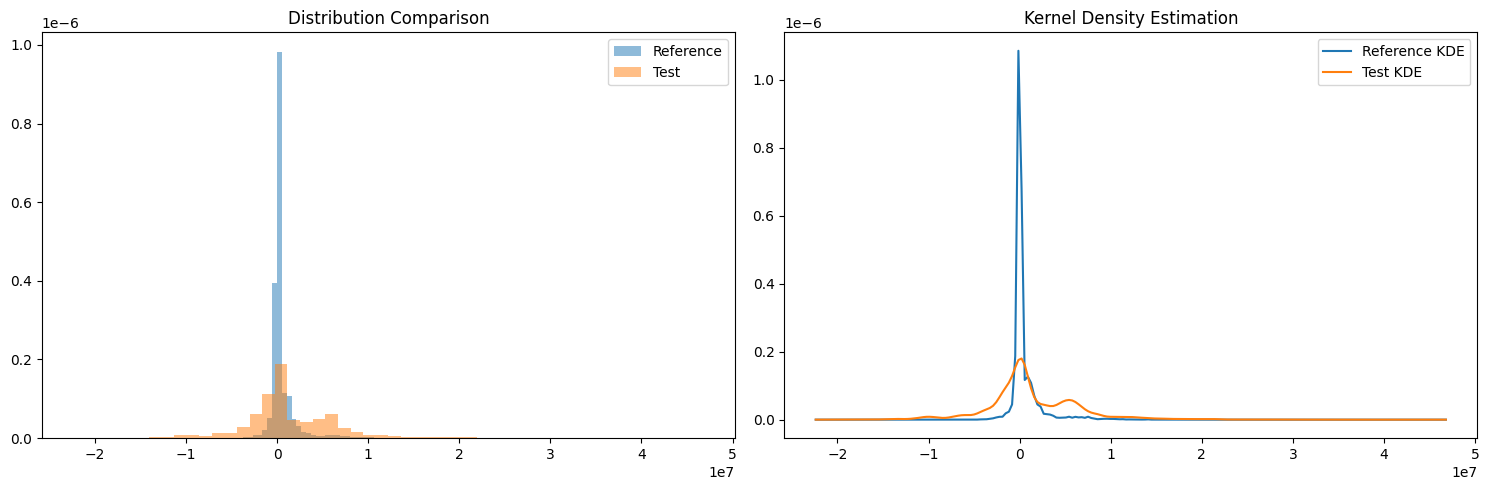

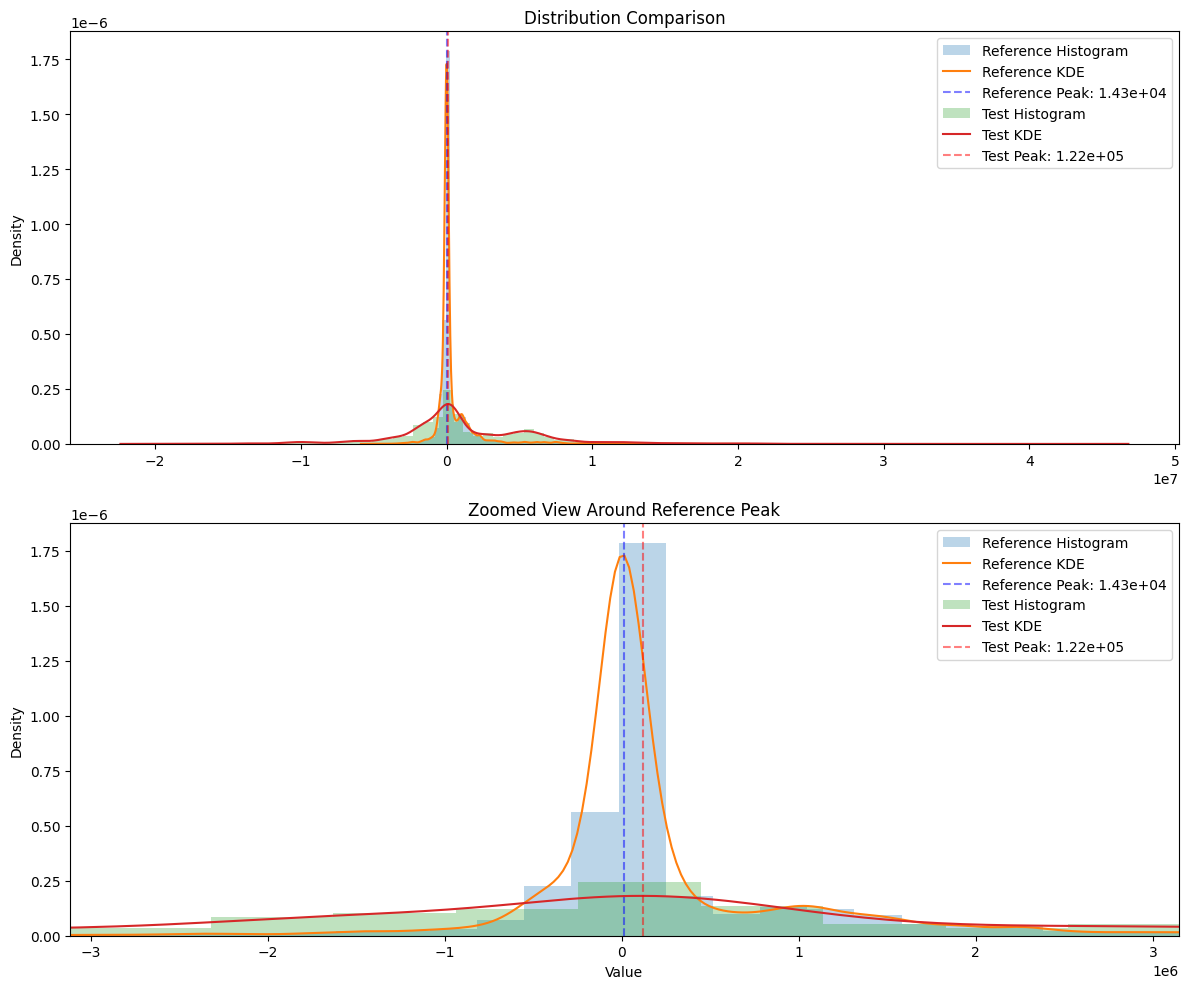

In [46]:
evaluation = evaluate_distribution_divergence(joined_df, recent_df_test1)
print_evaluation(evaluation)

analysis = analyze_distributions(joined_df, recent_df_test1)
print_analysis(analysis)


=== Distribution Evaluation Report ===

Overall Similarity Score: 67.61/100
Jensen-Shannon Divergence: 0.3239

Statistical Measures:
Mean Difference: 5.91%
Standard Deviation Difference: 15.37%

Evaluation Results:
Distribution Similarity: Low
Mean Deviation Acceptable: Yes
Std Deviation Acceptable: No

=== Peak Analysis Report ===

Peak Score (0-100): 96.97

Detailed Metrics:
Reference Peak Location: 1.43e+04
Test Peak Location: 6.25e+04
Absolute Peak Difference: 4.82e+04
Reference Standard Deviation: 1.57e+06
Peak Difference in Standard Deviation Units: 0.03

Interpretation: Excellent match (within 0.5 std)


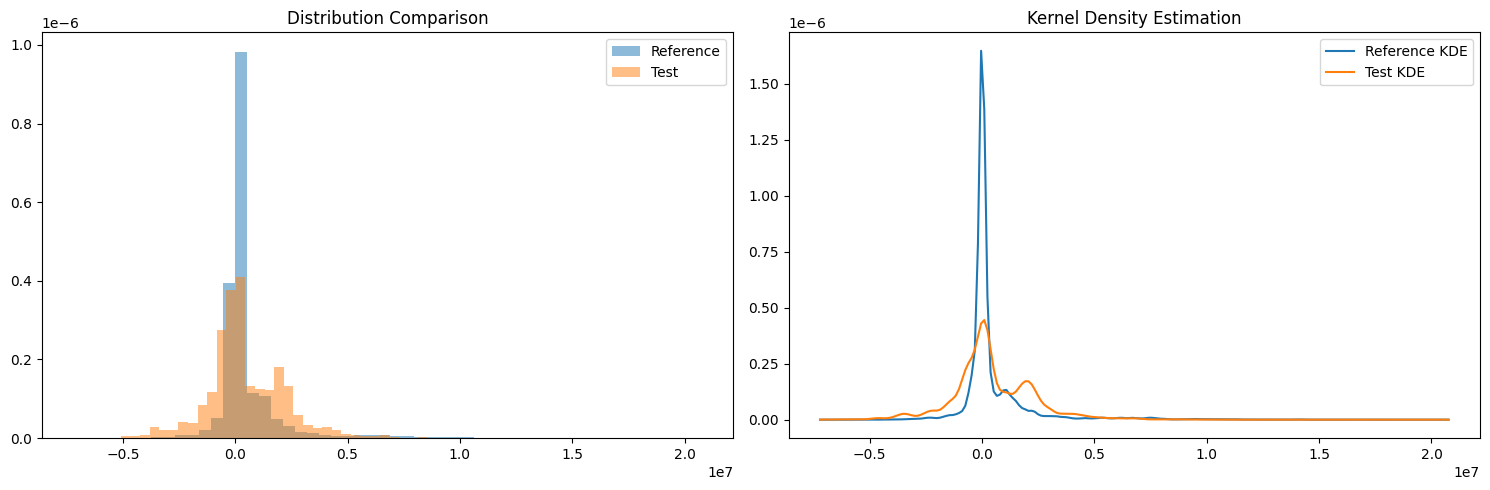

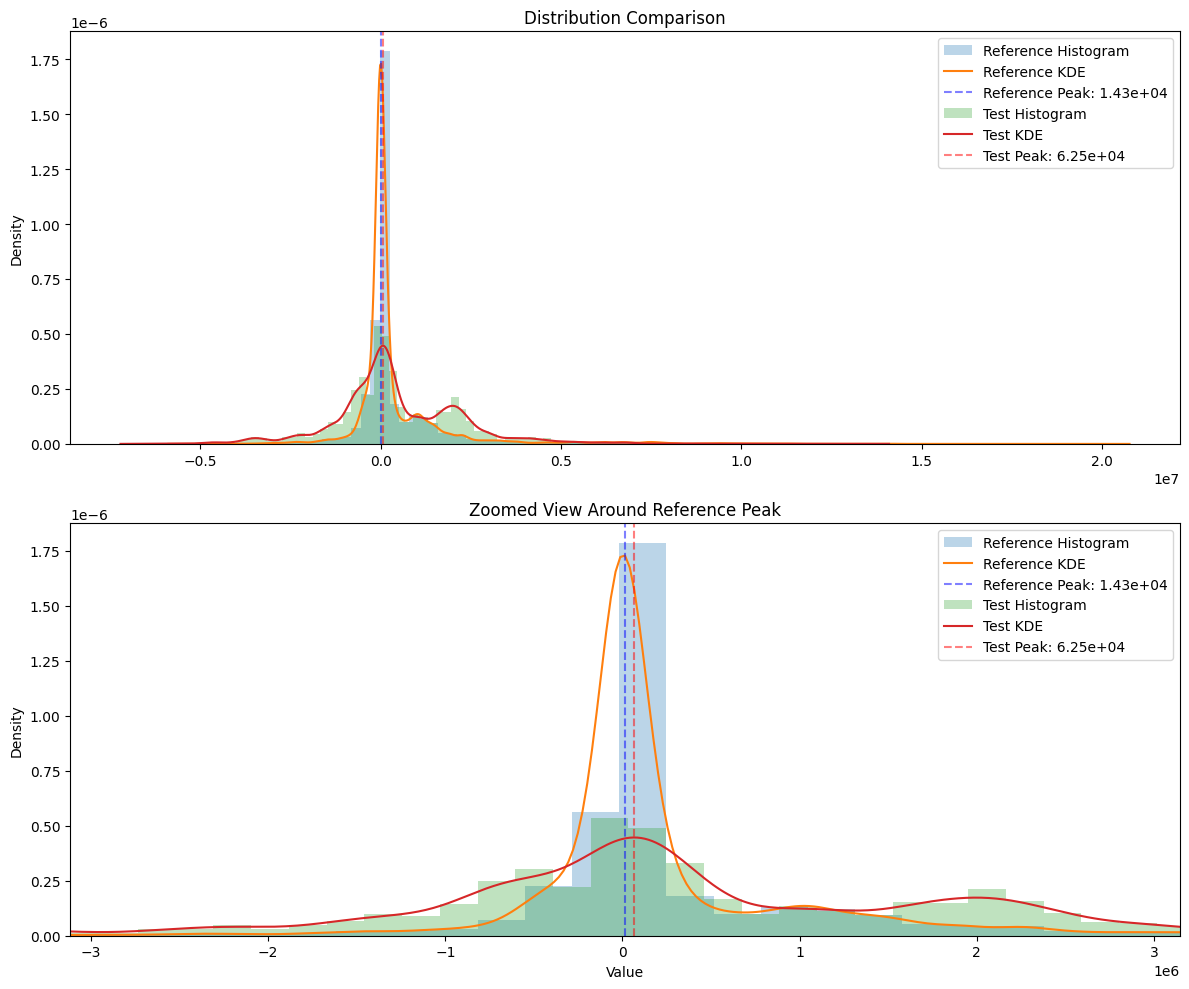

In [47]:
evaluation = evaluate_distribution_divergence(joined_df, recent_df_test2)
print_evaluation(evaluation)

analysis = analyze_distributions(joined_df, recent_df_test2)
print_analysis(analysis)


=== Distribution Evaluation Report ===

Overall Similarity Score: 77.93/100
Jensen-Shannon Divergence: 0.2207

Statistical Measures:
Mean Difference: -43.51%
Standard Deviation Difference: -38.47%

Evaluation Results:
Distribution Similarity: Medium
Mean Deviation Acceptable: No
Std Deviation Acceptable: No

=== Peak Analysis Report ===

Peak Score (0-100): 98.79

Detailed Metrics:
Reference Peak Location: 1.43e+04
Test Peak Location: 3.33e+04
Absolute Peak Difference: 1.91e+04
Reference Standard Deviation: 1.57e+06
Peak Difference in Standard Deviation Units: 0.01

Interpretation: Excellent match (within 0.5 std)


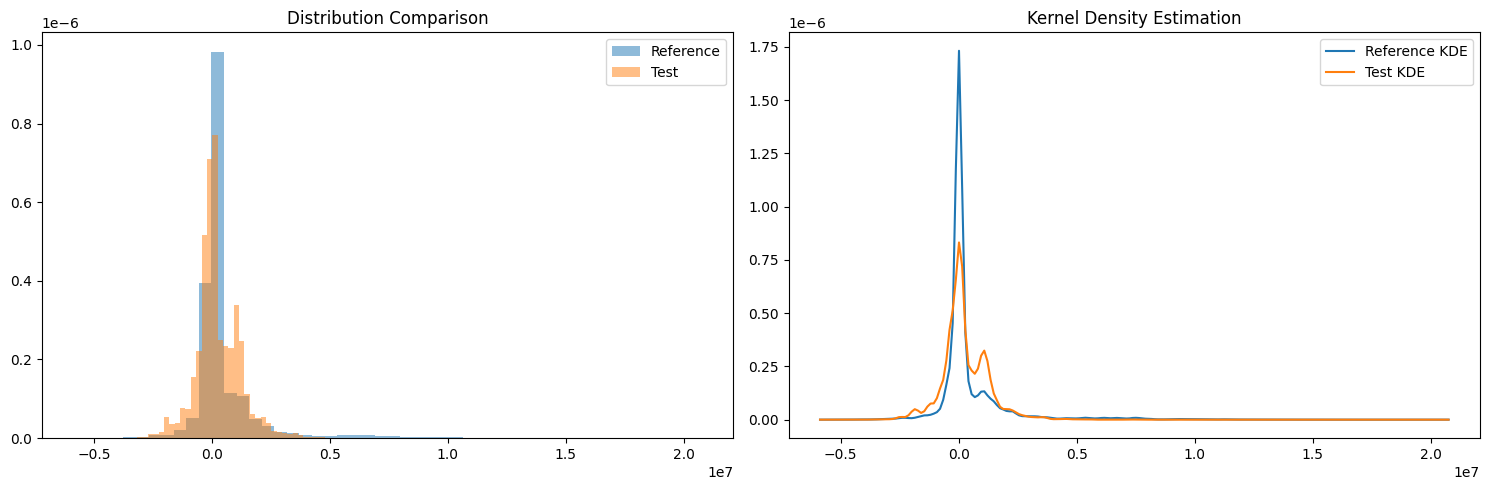

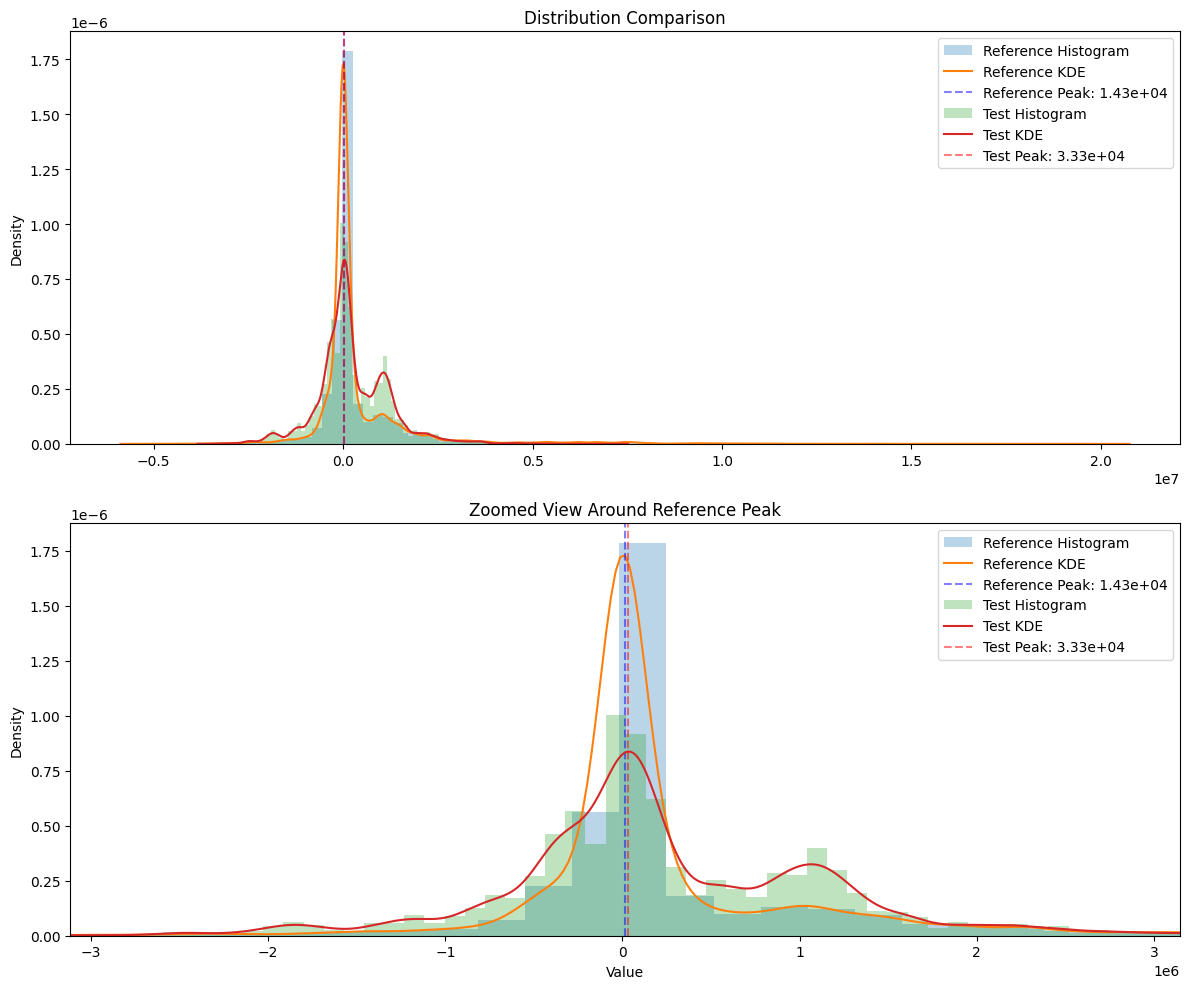

In [48]:
evaluation = evaluate_distribution_divergence(joined_df, recent_df_test3)
print_evaluation(evaluation)

analysis = analyze_distributions(joined_df, recent_df_test3)
print_analysis(analysis)


=== Distribution Evaluation Report ===

Overall Similarity Score: 52.70/100
Jensen-Shannon Divergence: 0.4730

Statistical Measures:
Mean Difference: 193.64%
Standard Deviation Difference: -23.08%

Evaluation Results:
Distribution Similarity: Low
Mean Deviation Acceptable: No
Std Deviation Acceptable: No

=== Peak Analysis Report ===

Peak Score (0-100): 51.89

Detailed Metrics:
Reference Peak Location: 1.43e+04
Test Peak Location: 1.04e+06
Absolute Peak Difference: 1.03e+06
Reference Standard Deviation: 1.57e+06
Peak Difference in Standard Deviation Units: 0.66

Interpretation: Good match (within 1 std)


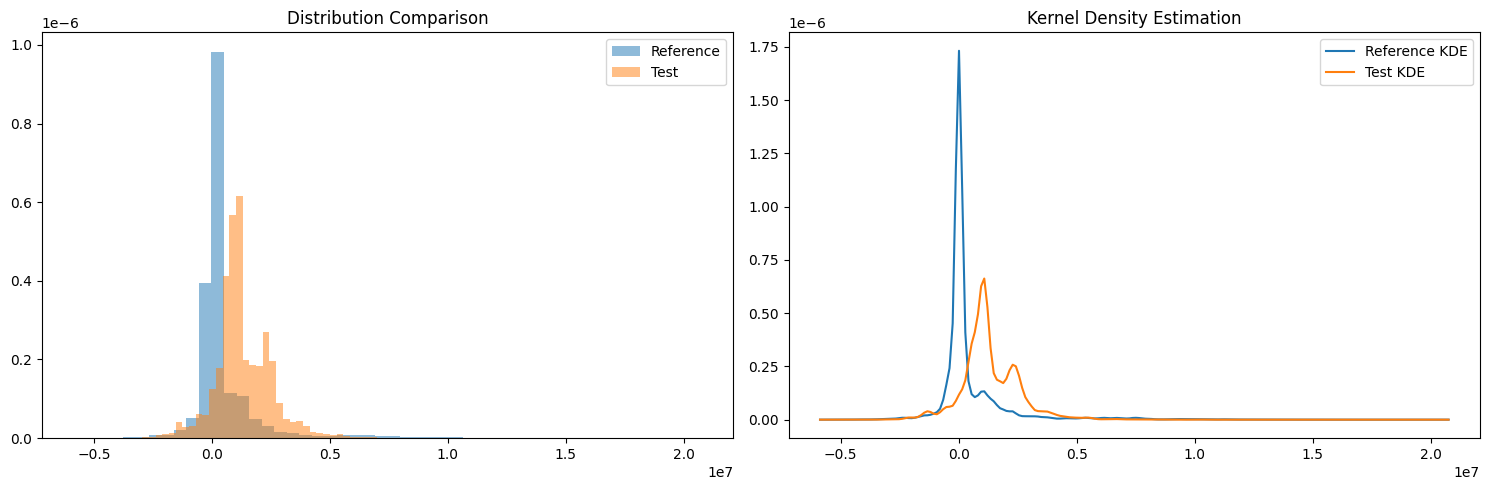

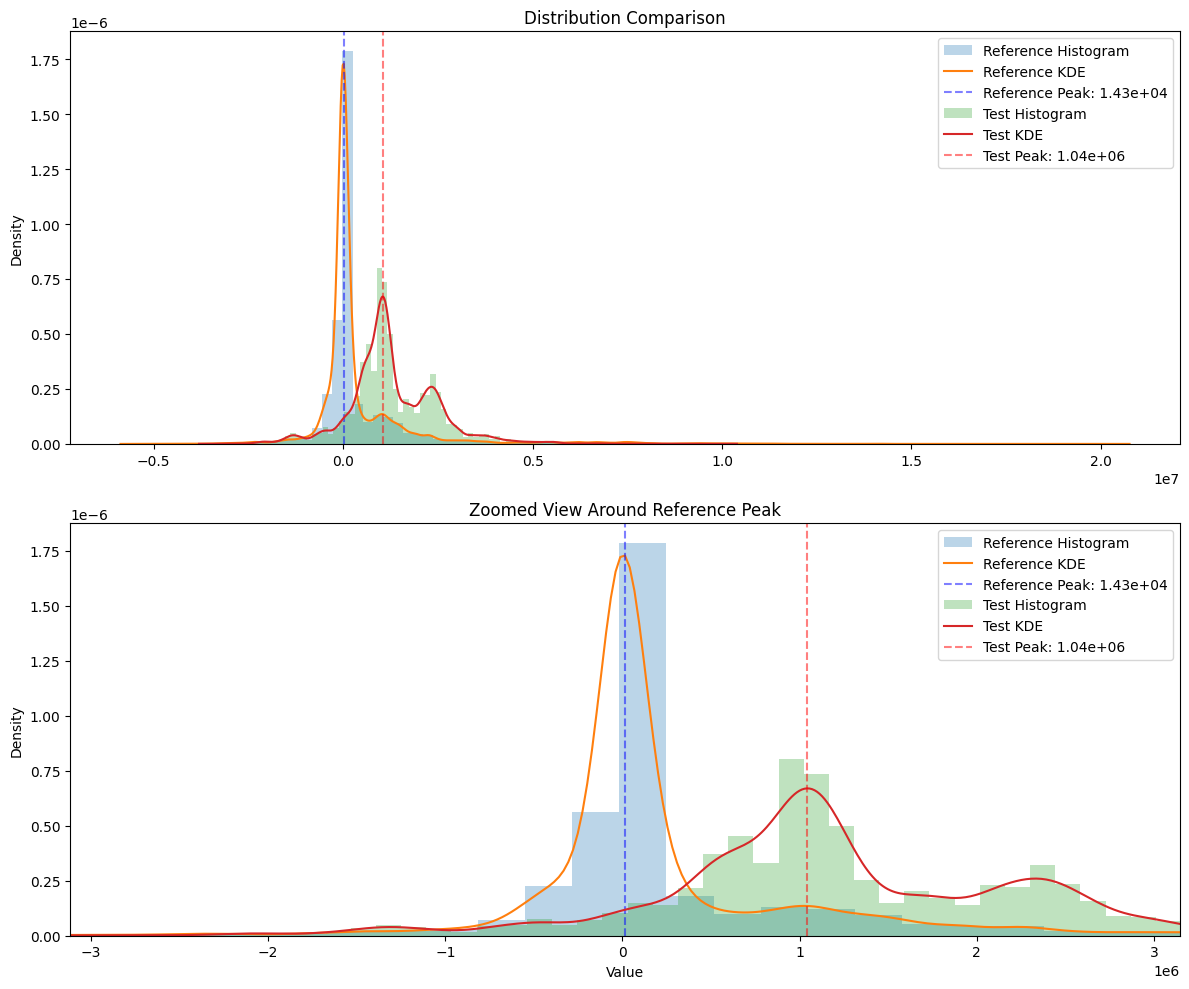

In [49]:
evaluation = evaluate_distribution_divergence(joined_df, recent_df_test4)
print_evaluation(evaluation)

analysis = analyze_distributions(joined_df, recent_df_test4)
print_analysis(analysis)


=== Distribution Evaluation Report ===

Overall Similarity Score: 51.15/100
Jensen-Shannon Divergence: 0.4885

Statistical Measures:
Mean Difference: -252.42%
Standard Deviation Difference: -23.08%

Evaluation Results:
Distribution Similarity: Low
Mean Deviation Acceptable: No
Std Deviation Acceptable: No


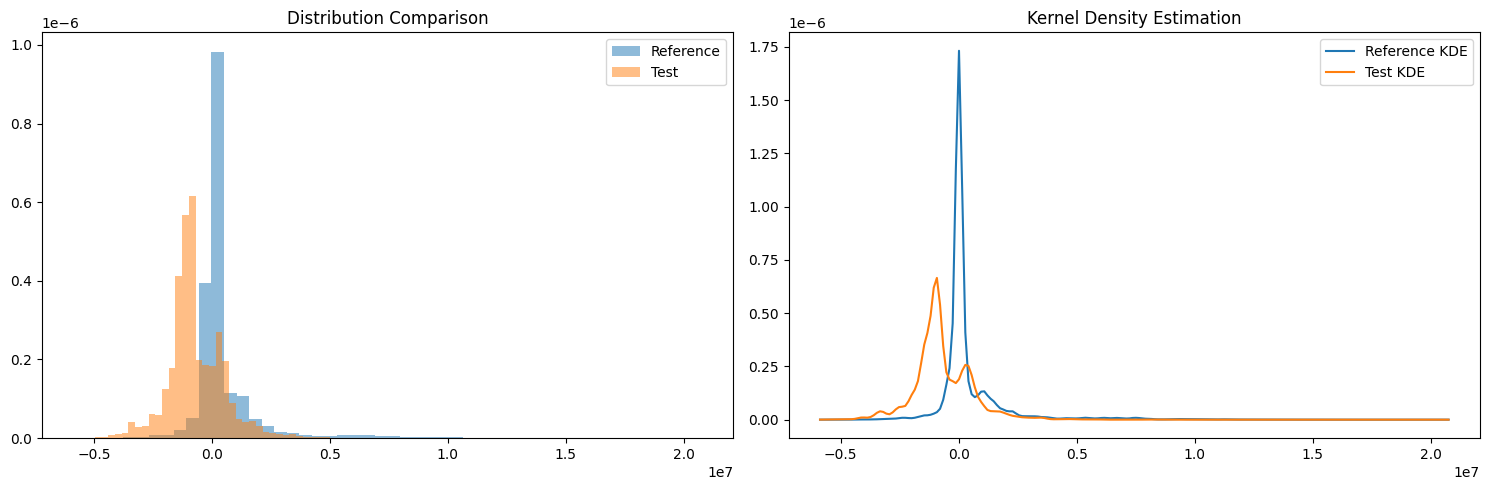

In [25]:
evaluation = evaluate_distribution_divergence(joined_df, recent_df_test5)
print_evaluation(evaluation)

---

In [26]:
def plot_llamma_product_data(joined_df: pd.DataFrame, block_number: int, period: int):
    """
    Plot Llamma data for a specific block number range
    
    Parameters:
    -----------
    joined_df : pd.DataFrame
        DataFrame containing the joined data
    block_number : int
        Center block number to analyze
    period : int
        Number of blocks before and after to include
    """
    # Filter data for the specified window
    mask = (joined_df['blockNumber'] >= block_number - period) & \
           (joined_df['blockNumber'] <= block_number + period)
    window_df = joined_df[mask]
    
    # Create figure and primary axis
    plt.style.use('default')
    fig, ax1 = plt.subplots(figsize=(21, 6))

    # Price data on primary axis
    scatter1 = ax1.scatter(window_df['blockNumber'], window_df['get_p'], 
                          color='blue', label='get_p', alpha=0.6)
    scatter2 = ax1.scatter(window_df['blockNumber'], window_df['price_oracle'], 
                          color='red', label='price_oracle', alpha=0.6)
    ax1.set_ylabel('Price (in crvUSD)', fontsize=12)

    # Secondary y-axis for amounts
    ax2 = ax1.twinx()

    # Stacked area charts
    ax2.scatter(window_df['blockNumber'], window_df['deviation_product'], 
                alpha=0.3, label='deviation_product', color='green')
    
    # ax2.fill_between(window_df['blockNumber'], window_df['crvUSD'], 
    #                  window_df['crvUSD'] + window_df['collateral'], 
    #                  alpha=0.3, label='collateral', color='purple')
    
    # Plot gains if they exist in the data
    if 'usdEquivalent' in window_df.columns:
        ax2.scatter(window_df['blockNumber'], window_df['usdEquivalent']*250000, 
                   color='black', label='Gains', alpha=0.6)
    
    ax2.set_ylabel('Collateral (in crvUSD)', fontsize=12)

    # Band information
    scatter_bands = ax2.scatter(window_df['blockNumber'], 
                              window_df['zero'], 
                              c=window_df['band'], cmap='viridis', 
                              alpha=0.2, s=20)

    # Colorbar
    cbar = plt.colorbar(scatter_bands)
    cbar.set_label('Band', fontsize=12)

    # Customize plot
    ax1.set_title(f'Llamma Prices & Collateral Composition in Bands\nBlock {block_number} ± {period}', 
                  fontsize=14, pad=15)
    ax1.set_xlabel('Block Number', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

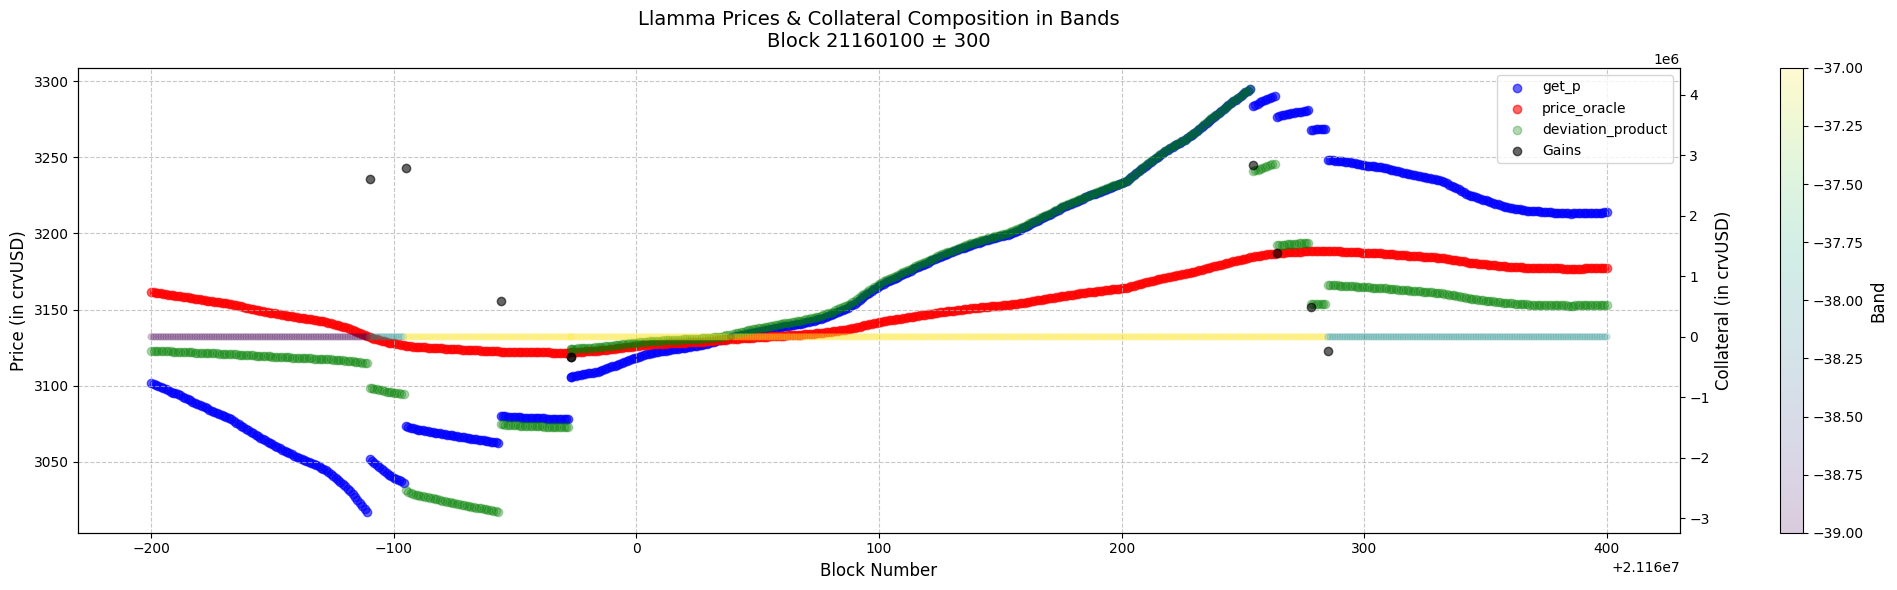

In [27]:
plot_llamma_product_data(joined_df, 21160100, 300)

In [28]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
